In [49]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio
from bisect import bisect_left
from matplotlib import cm
import matplotlib.ticker as mtick

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors, graph_weight_matrix
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.2e-3
BATCH_SIZE = 100

In [50]:
color_sets = [
    ('#EE82EE', '#8180ff'),
    ('#DA70D6', '#5959ff'),
    ('#97178F', '#040299'),
]

In [3]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [4]:

def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [5]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [6]:
def files_needed_from_timepoints(file_names, timepoints):
    file_idxs = (np.array(timepoints) / BATCH_SIZE).astype(int)
    rel_file_idxs = []
    tps_grouped = []
    
    last_file_idx = None
    for tp, file_idx in zip(timepoints, file_idxs):
        rel_idx = tp % BATCH_SIZE
        
        if file_idx == last_file_idx:
            rel_file_idxs[-1].append(rel_idx)
            tps_grouped[-1].append(tp)
        else:
            rel_file_idxs.append([rel_idx])
            tps_grouped.append([tp])
            last_file_idx = file_idx
    
    return zip(np.arange(len(rel_file_idxs)), np.array(file_names)[np.unique(file_idxs).astype(int)], rel_file_idxs, tps_grouped)

def attempt_load(name, source, dest):
    try:
        dest[name] = source[name]
        return True
    except ValueError as e:
        return False

def load_exp_data(direc, timepoints, layer_size=10, n_exc=1000, new_cell_idx=1000, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
        
    file_name_count = range(0, len(file_names))
    if reverse:
        file_name_count = reversed(file_name_count)
        
    files_needed = files_needed_from_timepoints(file_names, timepoints)
    
    l = 0
        
    for i, file, rel_file_idxs, tps in files_needed:
        loaded = sio.loadmat(os.path.join(direc, file))
        
        for j, rel_file_idx in enumerate(rel_file_idxs):
            loaded_rendition_data = loaded['data'][0][rel_file_idx]
            tp = tps[j]

            exc_raster = loaded_rendition_data['exc_raster'][0][0]
            inh_raster = loaded_rendition_data['inh_raster'][0][0]

            first_spk_times = process_single_activation(loaded_rendition_data['exc_raster'][0][0].astype(float), n_exc)

            layers_active = []
            layer_weights = []

            rendition_data = {
                'first_spk_times': first_spk_times,

                'w_e_e': loaded_rendition_data['w_e_e'][0],
                'w_e_i': loaded_rendition_data['w_e_i'][0],
                'w_i_e': loaded_rendition_data['w_i_e'][0],

                'exc_raster': exc_raster,
                'inh_raster': inh_raster,
                'freqs': loaded_rendition_data['freqs'][0],
                'spk_bins': loaded_rendition_data['spk_bins'][0],

                'exc_raster_unperturbed': exc_raster,
            }    
            
            attempt_load('gs', loaded_rendition_data, rendition_data)

            surviving_cell_mask = None
            if attempt_load('surviving_cell_mask', loaded_rendition_data, rendition_data):
                surviving_cell_mask = loaded_rendition_data['surviving_cell_mask'][0][0][0].astype(bool)
                rendition_data['surviving_cell_mask'] = surviving_cell_mask

                sorting_order = np.argsort(exc_raster[1, :])
                exc_raster_sorted = exc_raster[:, sorting_order]
                indices = np.arange(len(surviving_cell_mask))[surviving_cell_mask.astype(bool)]

                exc_raster_unperturbed = []
                exc_raster_perturbed = []

                k = 0
                for idx in np.arange(exc_raster_sorted.shape[1]):
                    if k >= len(indices):
                        exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] < indices[k]:
                        exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] == indices[k]:
                        exc_raster_unperturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] > indices[k]:
                        k += 1

                if len(exc_raster_unperturbed) == 0:
                    rendition_data['exc_raster_unperturbed'] = np.array([[]])
                else:
                    rendition_data['exc_raster_unperturbed'] = np.concatenate(exc_raster_unperturbed, axis=1)

                if len(exc_raster_perturbed) == 0:
                    rendition_data['exc_raster_perturbed'] = np.array([[]])
                else:
                    rendition_data['exc_raster_perturbed'] = np.concatenate(exc_raster_perturbed, axis=1)
                
            if attempt_load('w_r_e', loaded_rendition_data, rendition_data):
                rendition_data['w_r_e'] = loaded_rendition_data['w_r_e'][0][0]
                rendition_data['w_r_i'] = loaded_rendition_data['w_r_i'][0][0]
                
                w_r_e = rendition_data['w_r_e']

                w_r_e_e = w_r_e[:n_exc, :n_exc]
                w_r_e_i = w_r_e[n_exc:, :n_exc]

                if surviving_cell_mask is not None:
                    w_r_e_e_surviving = w_r_e_e[(surviving_cell_mask & (np.arange(n_exc) < new_cell_idx)).astype(bool), :]
                    summed_incoming_weights_e_e = np.sum(w_r_e_e_surviving[:, surviving_cell_mask], axis=1)
                    summed_incoming_weights_e_i = np.sum(w_r_e_i[:, surviving_cell_mask], axis=1)
                else:
                    summed_incoming_weights_e_e = np.sum(w_r_e_e, axis=1)
                    summed_incoming_weights_e_i = np.sum(w_r_e_i, axis=1)

                rendition_data['summed_incoming_weights_e_e'] = summed_incoming_weights_e_e
                rendition_data['mean_incoming_summed_weights_e_e'] = np.mean(summed_incoming_weights_e_e)
                rendition_data['std_incoming_summed_weights_e_e'] = np.std(summed_incoming_weights_e_e)
                rendition_data['mean_incoming_summed_weights_e_i'] = np.mean(summed_incoming_weights_e_i)
                rendition_data['std_incoming_summed_weights_e_i'] = np.std(summed_incoming_weights_e_i)

            yield tp, rendition_data

In [7]:
def determine_recovered(names, initial_timepoints, final_timepoints, threshold=0.9, n_excs=[]):
    recovered_dir_names = []
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    all_recovery_pers = []
    all_n_eligible = []
    for k, exp_dir_names in enumerate(all_dirs):
        per_recovered_for_name = 0
        n_eligible_for_name = 0
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            
            n_count_initial = 0
            n_active_initial = 0
            n_count_final = 0
            n_active_final = 0
            last_layer_actives = []
            
            timepoints = np.concatenate([initial_timepoints, final_timepoints])
            
            for tp, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, name_frags=[], n_exc=n_excs[k]):
                
                begin_avg_spk_time = np.nanmean(data['first_spk_times'][:30])
                middle_avg_spk_time = np.nanmean(data['first_spk_times'][100:120])
                end_avg_spk_time = np.nanmean(data['first_spk_times'][180:200])
                
                active = int((np.any(data['first_spk_times'] > 0.08)) &
                                (middle_avg_spk_time > begin_avg_spk_time) &
                                (end_avg_spk_time > middle_avg_spk_time))
                
                if tp in initial_timepoints:
                    n_count_initial += 1
                    n_active_initial += active
                else:
                    n_count_final += 1
                    n_active_final += active
                    
            if n_active_initial / n_count_initial < 0.9:
                continue

            n_eligible_for_name += 1
                
            
            if not n_count_final == 0 and n_active_final / n_count_final >= threshold:
                print('X')
                recovered_dir_names.append(exp_dir_name)
                per_recovered_for_name += 1
        if  n_eligible_for_name == 0:
            per_recovered_for_name = 0
        else:
            per_recovered_for_name /= n_eligible_for_name
        all_recovery_pers.append(per_recovered_for_name)
        all_n_eligible.append(n_eligible_for_name)
        
    return recovered_dir_names, all_recovery_pers, all_n_eligible

In [8]:
recovered_exp_names, all_recovery_pers, all_n_eligible = determine_recovered([   
    ['DROP_SEV_0.1', 'secreted_regulation', 'A5_0.5'],
    ['DROP_SEV_0.25', 'secreted_regulation', 'A5_0.5'],
    ['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5'],
    ['DROP_SEV_0.1', 'firing_rate', 'A5_0.5'],
    ['DROP_SEV_0.25', 'firing_rate', 'A5_0.5'],
    ['DROP_SEV_0.5', 'firing_rate', 'A5_0.5'],
], np.arange(900, 990, 10), np.arange(3000, 3500, 10), n_excs=[200] * 12)

print(all_recovery_pers)
print(all_n_eligible)

secreted__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:1855
X
secreted__SEED_2023_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:3219
X
secreted__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:7375
X
secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6059
X
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6544
X
secreted__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no

X
secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:9033
X
secreted__SEED_2004_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:5876
X
secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:2681
X
secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:2681
X
secreted__SEED_2006_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:2415
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl

X
secreted__SEED_2022_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--22:43--26:0093
X
secreted__SEED_2018_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:8822
X
secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:6059
X
secreted__SEED_2004_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:5876
X
secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:6435
secreted__SEED_2020_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:9861
secre

X
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:6544
secreted__SEED_2011_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:9272
secreted__SEED_2001_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:1671
secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:9033
X
secreted__SEED_2018_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:8822
X
[1.0, 0.9565217391304348, 0.9565217391304348, 1.0, 1.0, 1.0]
[23, 23, 23, 14, 14, 14]


In [38]:
def downsample_raster(raster, cell_idxs_to_show):
    j = 0
    if raster.size == 0:
        return np.array([])
    sorted_raster = np.array([y for y in sorted(raster.T, key=lambda x: x[1])]).T
    downsampled = []
    for i in range(sorted_raster.shape[1]):
        while j < len(cell_idxs_to_show) and sorted_raster[1, i] > cell_idxs_to_show[j]:
            j += 1
        if j == len(cell_idxs_to_show):
            break
        if sorted_raster[1, i] == cell_idxs_to_show[j]:
            downsampled.append(sorted_raster[:, i])
    if len(downsampled) > 0:
        return np.stack(downsampled).T
    else:
        return np.array([])
    
def a_not_in_b_mask(a, b):
    l = []
    for a_i in a:
        if a_i not in b:
            l.append(1)
        else:
            l.append(0)
    return np.array(l).astype(bool)

def make_figure_1_sparse(name, cell_range=(0, 900), new_cell_idx=None, per_shown=1., layer_size=10, timepoints=[5, 9, 20], sort_timepoint=300, color='black'):
    n_cells = cell_range[1] - cell_range[0]
    
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    count = 0
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
#         if count >= 3:
#             break
        print(exp_dir_name)
        count += 1
            
        scale = 0.8
        fig = plt.figure(constrained_layout=True, figsize=(5 * len(timepoints) * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=len(timepoints), nrows=3, figure=fig)
        axs = [(fig.add_subplot(gs[:1, i]), fig.add_subplot(gs[1:, i])) for i in range(len(timepoints))]
           
        timepoint_names = [rendition_label(t) for t in timepoints]
        
        cell_idxs_to_show = None
        cell_idx_names = None
        sorted_order = None
        
        unperturbed_exc_rasters = []
        inh_rasters = []

        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, n_exc=n_cells, new_cell_idx=new_cell_idx, name_frags=[], reverse=False):
            if i == sort_timepoint:
                first_spk_times = data['first_spk_times']
                first_spk_times[np.isnan(first_spk_times)] = first_spk_times.max() + np.arange(np.sum(np.isnan(first_spk_times)))
                firing_idxs = np.arange(len(first_spk_times))
                
                cell_idxs_to_show = firing_idxs[np.logical_and(firing_idxs >= cell_range[0], firing_idxs < cell_range[1])].astype(int)
                shown_first_spk_times = first_spk_times[np.logical_and(firing_idxs >= cell_range[0], firing_idxs < cell_range[1])]
                
                cell_idx_to_order_map = np.zeros(np.max(cell_idxs_to_show) + 1).astype(int)
                for idx in range(len(cell_idxs_to_show)):
                    cell_idx_to_order_map[cell_idxs_to_show[idx]] = idx
                
                sorted_order = np.nan * np.ones(len(shown_first_spk_times))
                for idx2, k in enumerate(np.argsort(shown_first_spk_times)):
                    sorted_order[k] = idx2
                sorted_order = sorted_order[cell_idx_to_order_map]
            
            unperturbed_exc_rasters.append(data['exc_raster_unperturbed'])
            inh_rasters.append(data['inh_raster'])
                
        for i, timepoint in enumerate(timepoints):
            unperturbed_exc_raster = unperturbed_exc_rasters[i]
            inh_raster = inh_rasters[i]
            
            initially_active_mask = np.ones(unperturbed_exc_raster.shape[1])
            initially_active_mask[unperturbed_exc_raster[1, :] >= new_cell_idx] = 0
            initially_active_mask[a_not_in_b_mask(unperturbed_exc_raster[1, :], unperturbed_exc_rasters[0][1, :])] = 0
            initially_active_mask = initially_active_mask.astype(bool)
            
            newly_active_mask = ~initially_active_mask
            
            exc_cells_initially_active = unperturbed_exc_raster[:, initially_active_mask]
            exc_cells_newly_active = unperturbed_exc_raster[:, newly_active_mask]
            
            exc_cells_initially_active_downsampled = downsample_raster(exc_cells_initially_active, cell_idxs_to_show)
            exc_cells_newly_active_downsampled = downsample_raster(exc_cells_newly_active, cell_idxs_to_show)
                
            if len(exc_cells_initially_active_downsampled) == 0:
                continue
                    
            axs[i][1].scatter(exc_cells_initially_active_downsampled[0, :] * 1000, sorted_order[exc_cells_initially_active_downsampled[1, :].astype(int)], s=10, c='black', zorder=0, alpha=1, marker='|')
            if exc_cells_newly_active_downsampled.size > 0:
                axs[i][1].scatter(exc_cells_newly_active_downsampled[0, :] * 1000, sorted_order[exc_cells_newly_active_downsampled[1, :].astype(int)], s=10, c='#FF00FF', zorder=0, alpha=1, marker='|')
                    
                    
            if len(inh_raster) > 0:
                axs[i][0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - n_cells, s=10, c='blue', zorder=0, alpha=1, marker='|')
            axs[i][1].set_ylim(0, n_cells)
            axs[i][0].set_ylim(0, 30)
            axs[i][0].set_ylabel('Inhibitory\ncell Index')
            axs[i][1].set_ylabel('Excitatory\ncell Index')
            axs[i][1].set_xlabel('Time (ms)')
            axs[i][0].title.set_text(f'{timepoint_names[i]}')

            axs[i][0].spines['bottom'].set_visible(False)
            axs[i][1].spines['top'].set_visible(False)
            axs[i][0].tick_params(bottom=False, labelbottom=False)

            for row_idx in range(2):
                axs[i][row_idx].set_xlim(0.01 * 1000, 0.1 * 1000)
                set_font_size(axs[i][row_idx], 16)
                axs[i][row_idx].spines['right'].set_visible(False)
                axs[i][row_idx].set_ylim(6)
        
        fig.tight_layout()  
#         save_fig(fig, './figures/paper/rasters', f'{exp_dir_name}.svg')

secreted__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--44:5704


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2001_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--44:1671


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6544


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2003_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:4922


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2004_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:5876


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:1805


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6435


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:2681


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0602


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2010_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0424


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2011_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:9272


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2012_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0713


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2013_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6753


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:1855


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:7375


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2016_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:8966


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2017_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0209


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2018_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:8822


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:9033


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6059


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2022_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0093


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2023_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:3219


<ipython-input-38-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


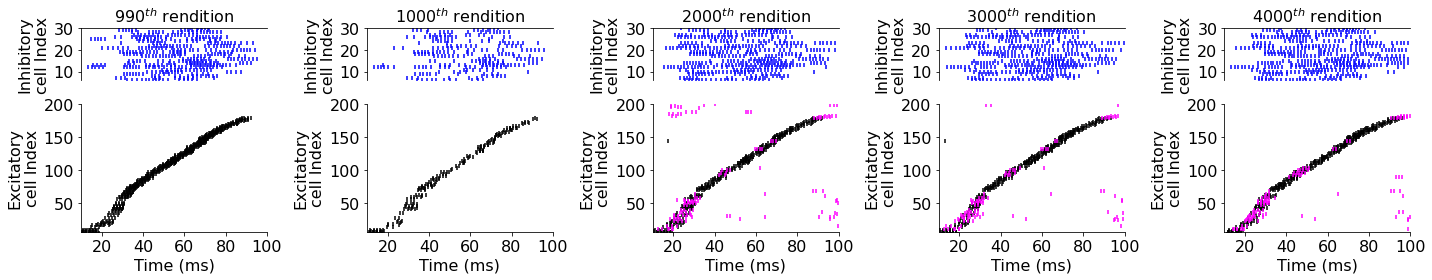

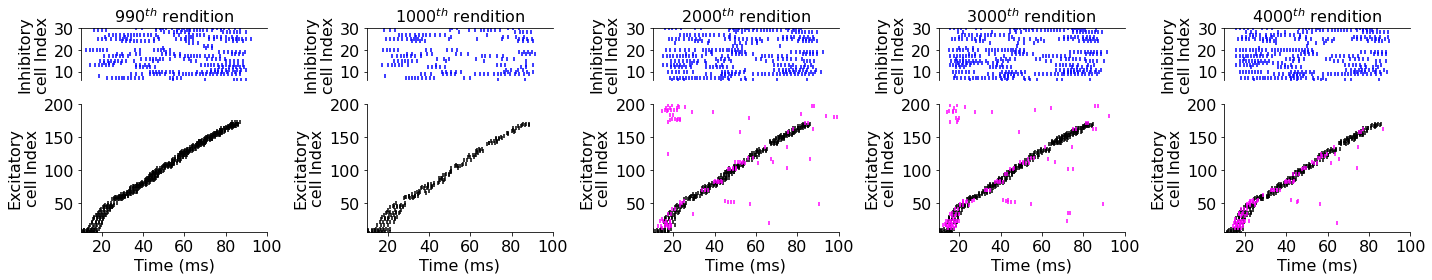

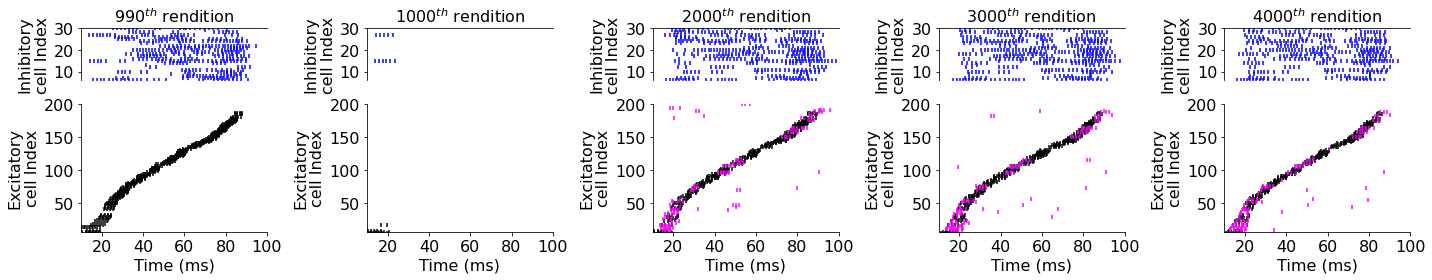

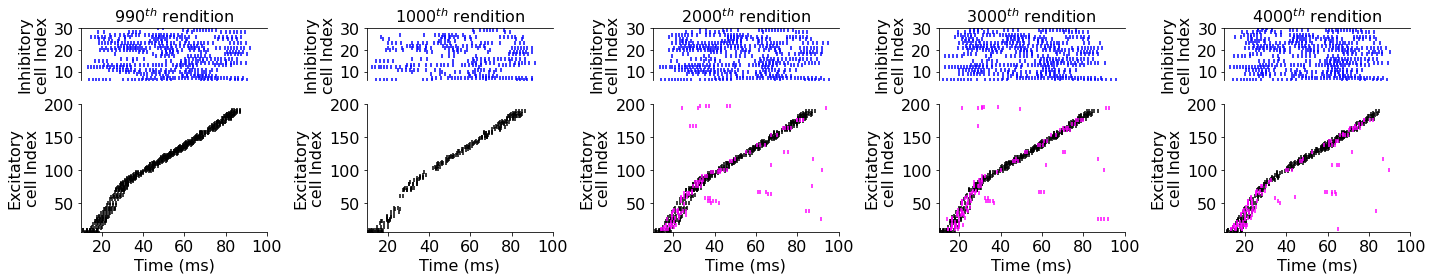

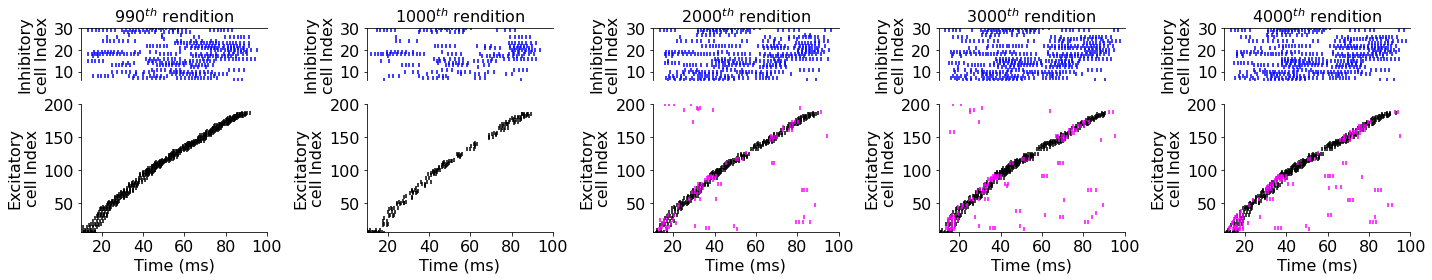

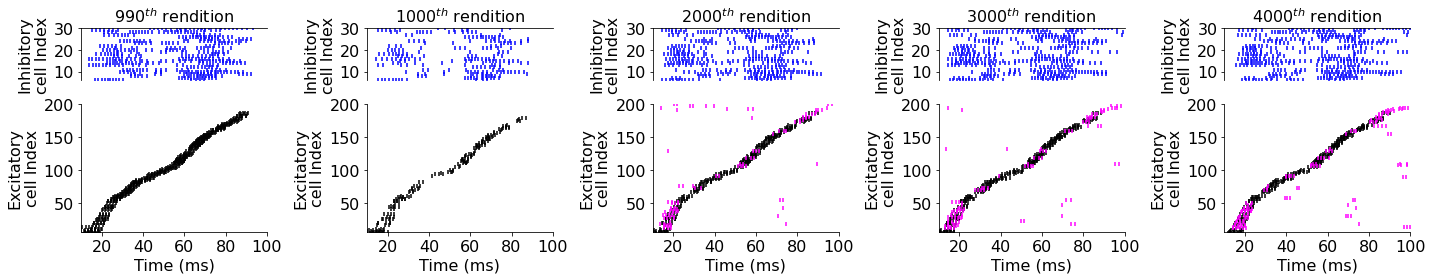

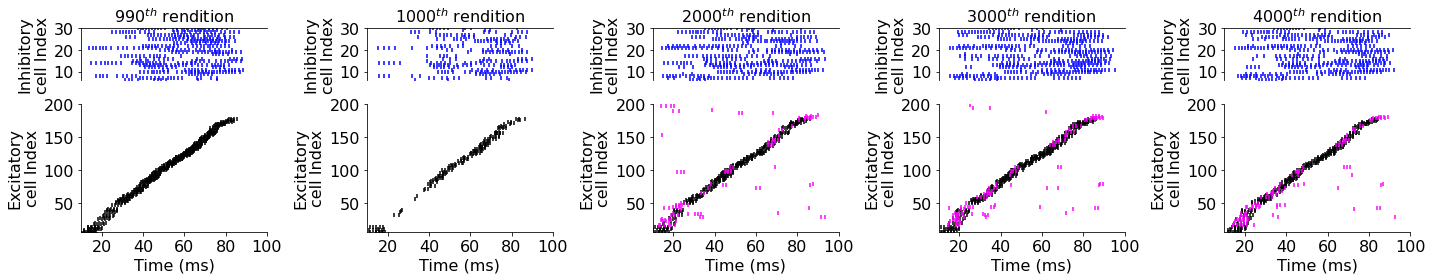

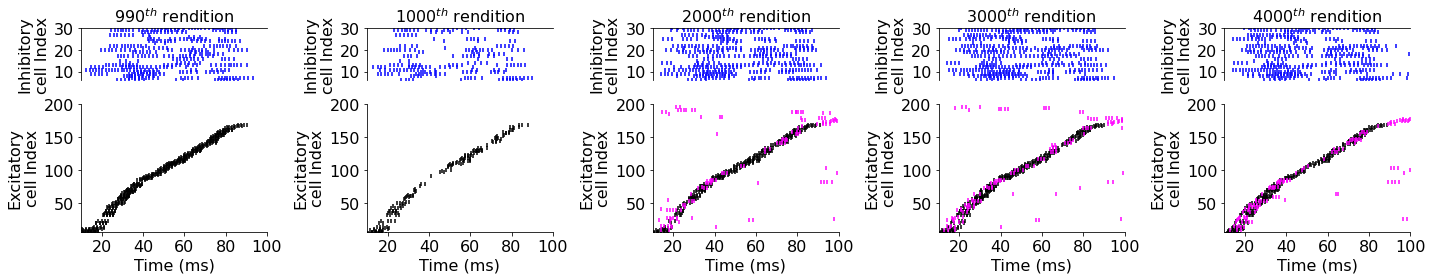

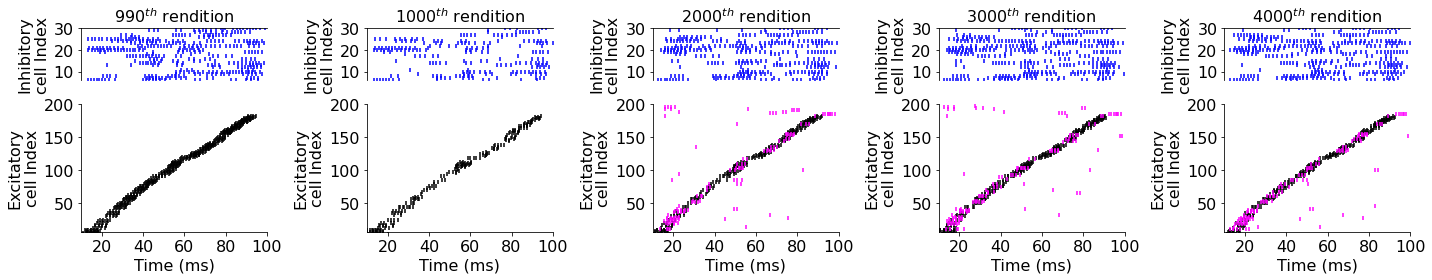

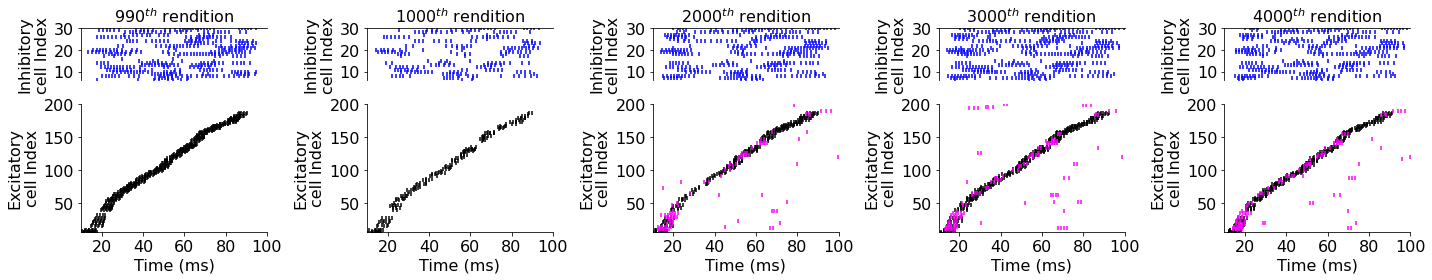

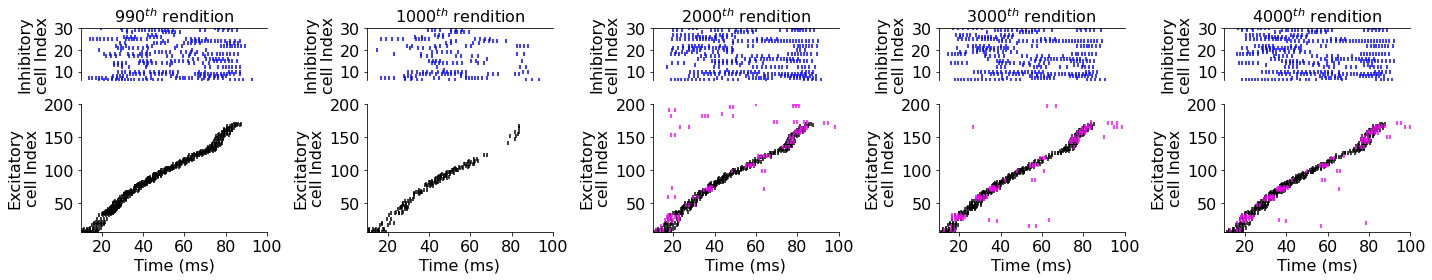

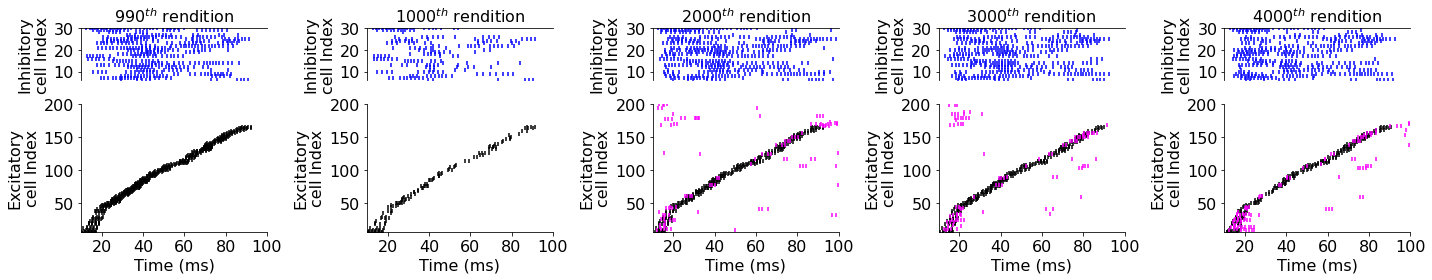

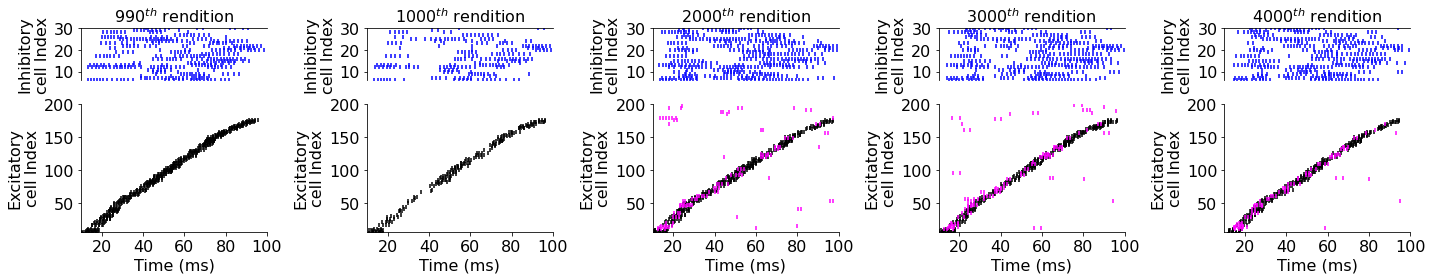

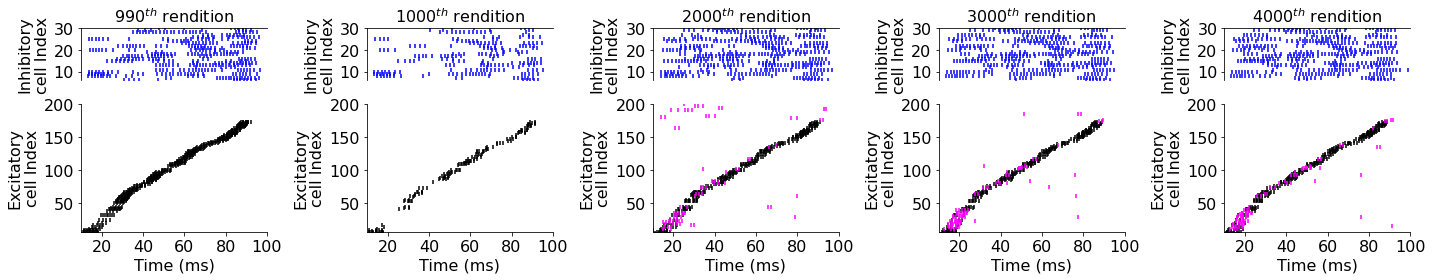

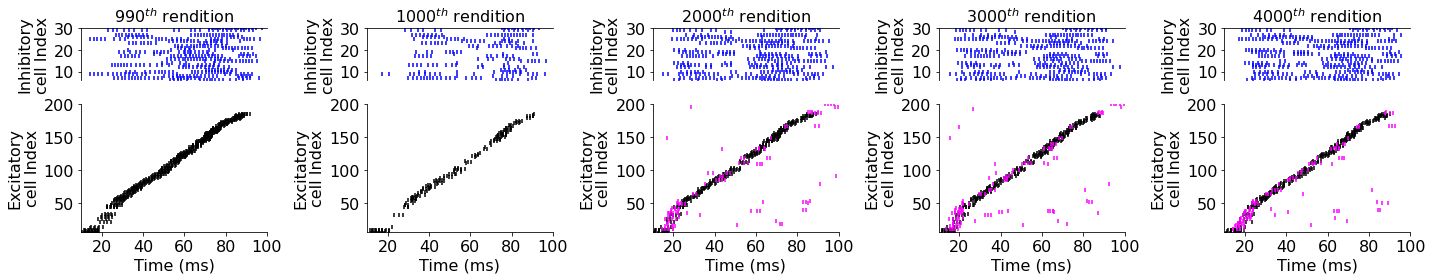

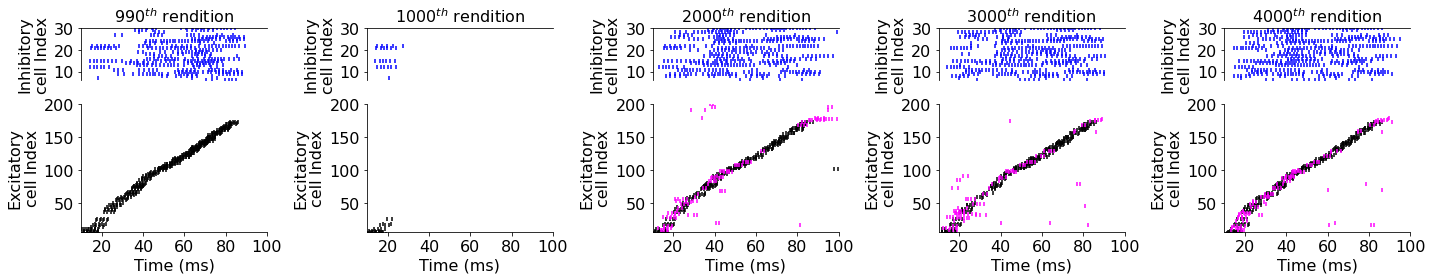

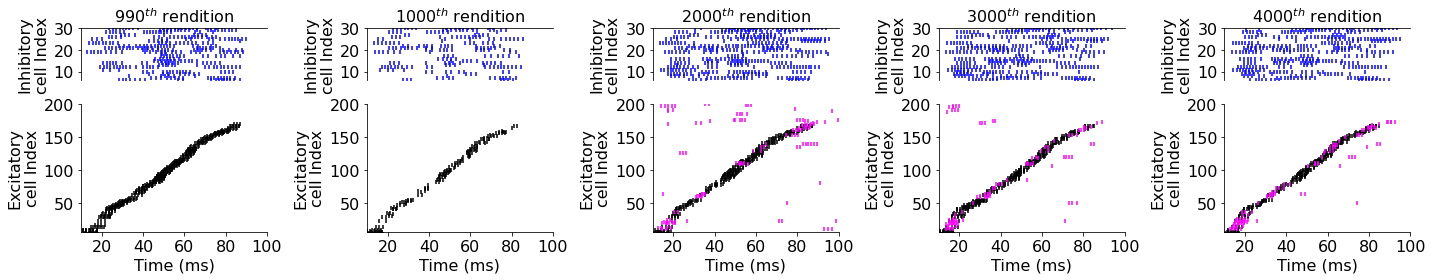

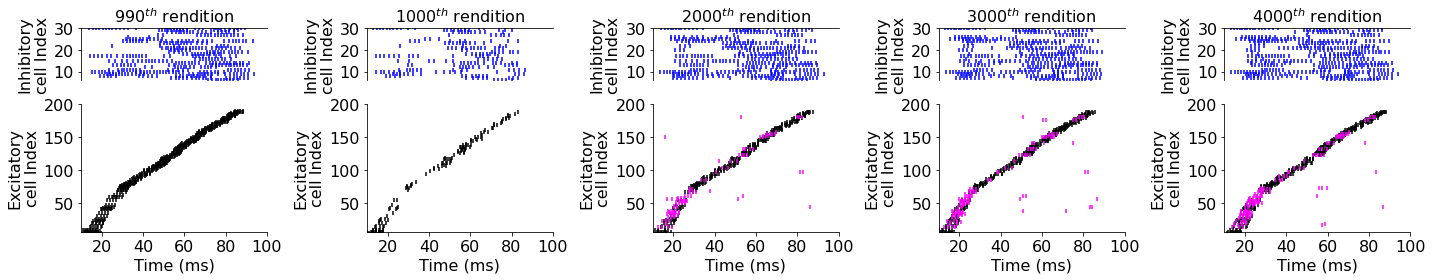

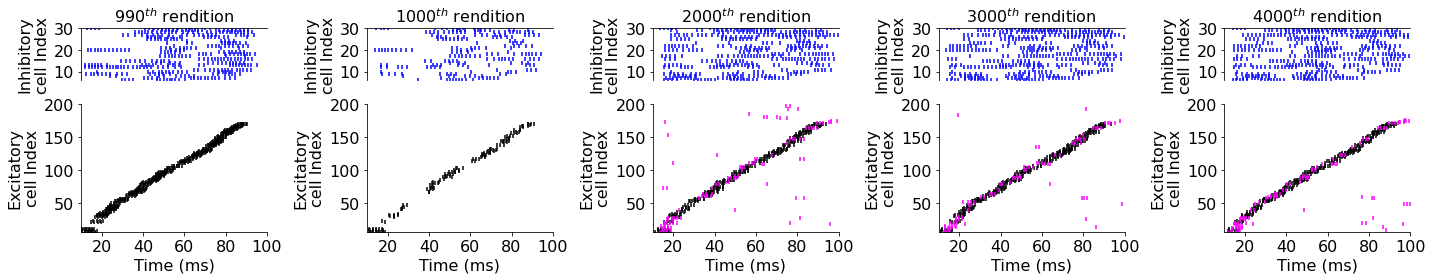

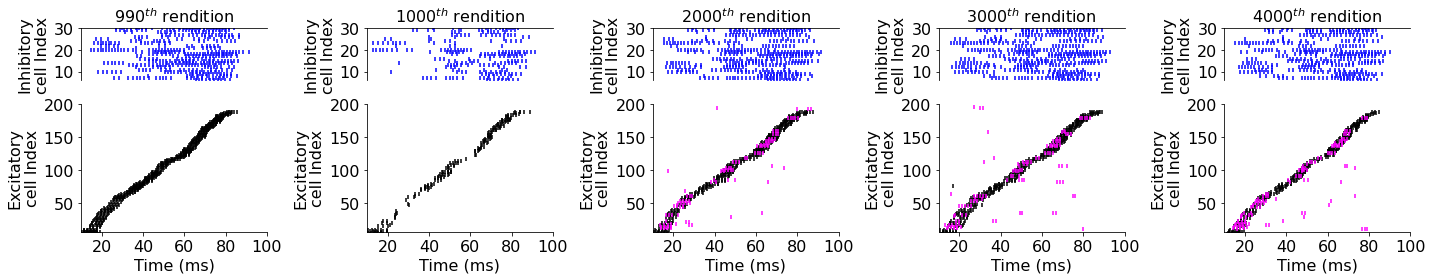

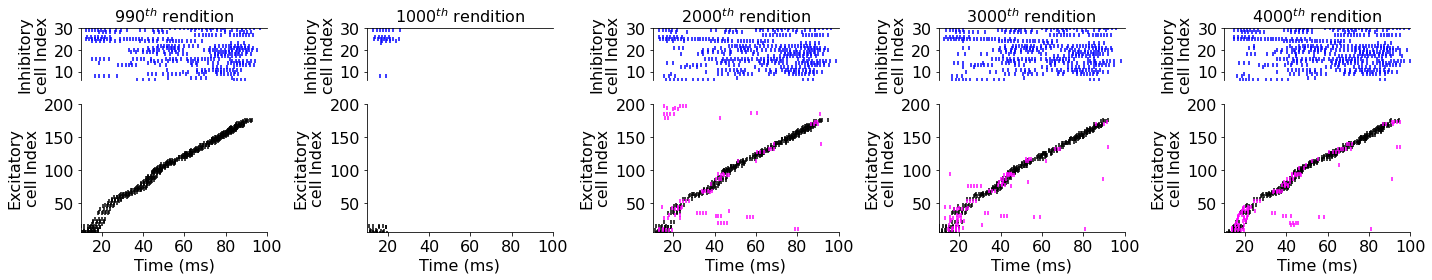

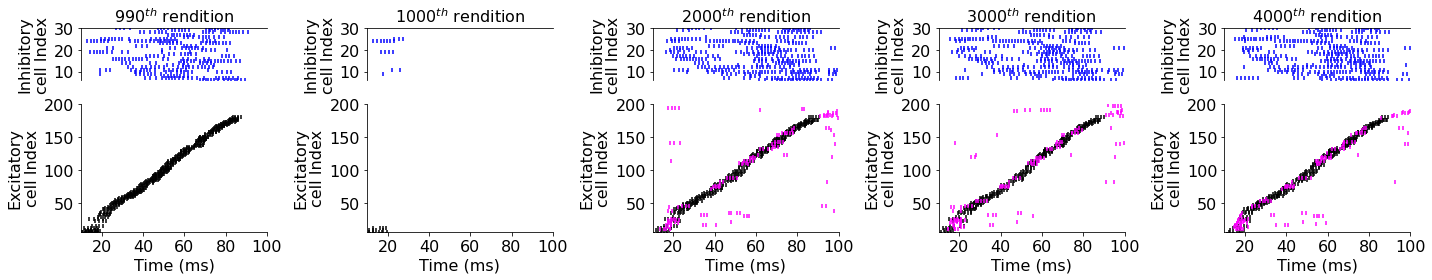

In [39]:
make_figure_1_sparse(
    ['DROP_SEV_0.25', 'secreted_regulation', 'A5_0.5'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints=[990, 1000, 2000, 3000, 4000],
    sort_timepoint=4000,
    per_shown=1.,
    color='#c41f3b',
)

secreted__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:5704


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2004_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:5876


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:1805


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:2681


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:0602


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2010_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:0424


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2012_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:0713


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2013_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:6753


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:1855


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:7375


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2018_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:8822


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:9033


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:6059


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


secreted__SEED_2022_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--22:43--26:0093


<ipython-input-64-eefe72c08bcb>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


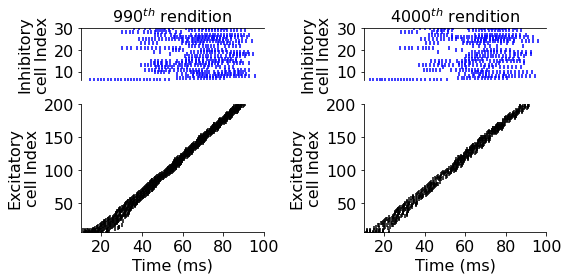

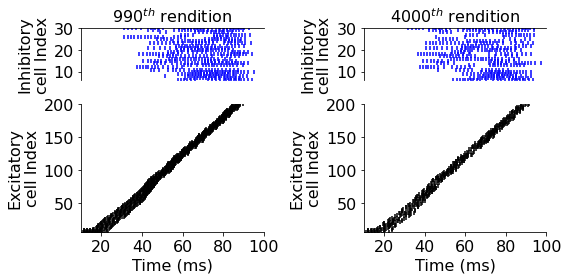

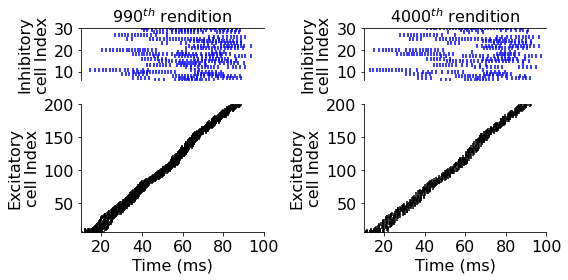

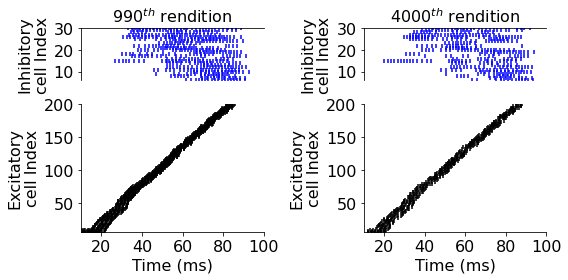

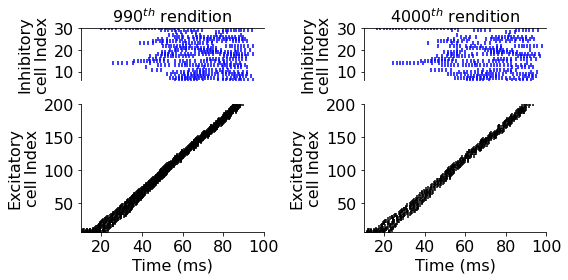

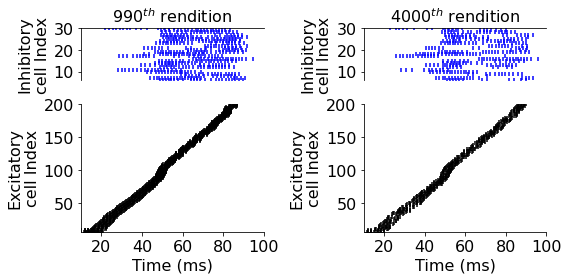

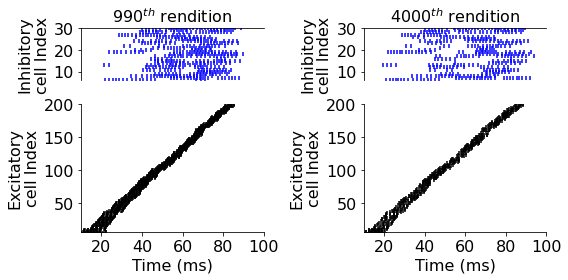

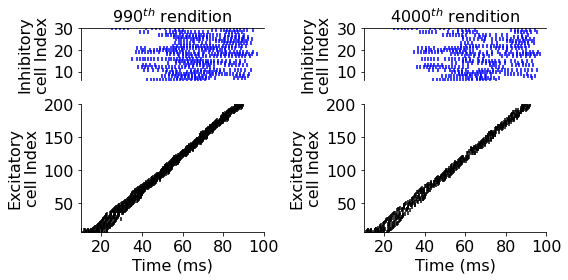

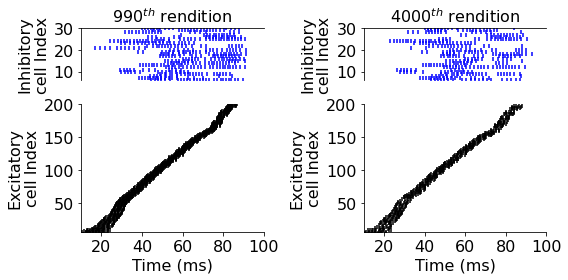

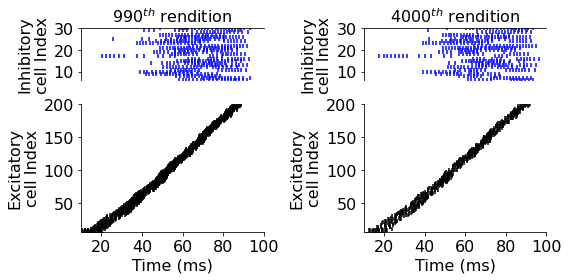

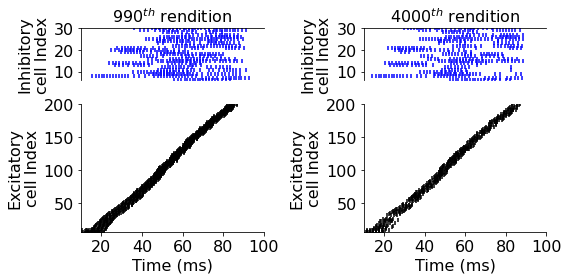

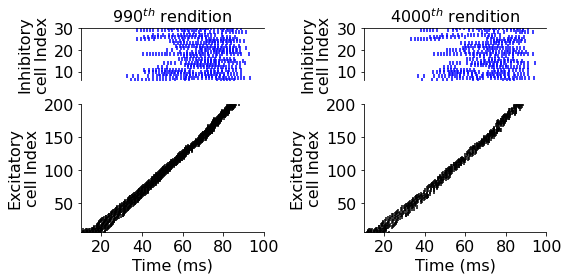

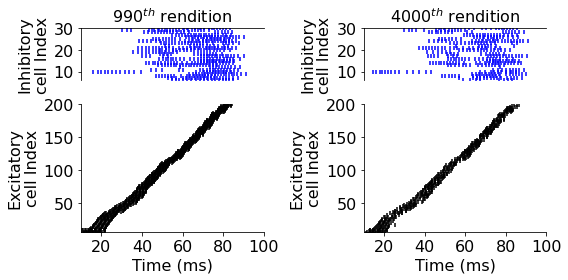

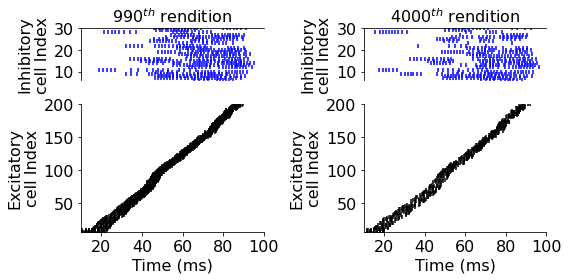

In [66]:
make_figure_1_sparse(
    ['DROP_SEV_0.25', 'firing_rate', 'A5_0.5'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints=[990, 4000],
    sort_timepoint=4000,
    per_shown=1.,
    color='#c41f3b',
)

In [64]:
def make_total_activity_plot(names, labels, condition_colors, n_excs=[450], file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 1.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        e_activity = []
        i_activity = []
        
        count = 0
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue

            print(exp_dir_name)
                    
            all_mean_e_activity = []
            all_mean_i_activity = []
            baseline_mean_e = None
            baseline_mean_i = None

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, n_exc=n_excs[idx], name_frags=[], new_cell_idx=200):
                
                all_mean_e_activity.append(np.count_nonzero(data['exc_raster_unperturbed']))
                all_mean_i_activity.append(np.count_nonzero(data['inh_raster']))
                
                if i == offsets[idx]:
                    baseline_mean_e = np.count_nonzero(data['exc_raster_unperturbed'])
                    baseline_mean_i = np.count_nonzero(data['inh_raster'])
            
            all_mean_e_activity = np.array(all_mean_e_activity) / baseline_mean_e
            all_mean_i_activity = np.array(all_mean_i_activity) / baseline_mean_i
            
            if np.max(all_mean_e_activity[:5]) < 1.2 and np.max(all_mean_i_activity[:5]) < 1.2:
                e_activity.append(all_mean_e_activity)
                i_activity.append(all_mean_i_activity)
                count += 1

#                 axs[0].plot(timepoints[:len(all_mean_e_activity)], all_mean_e_activity, color=condition_colors[idx][0], lw=0.5, zorder=-1)
#                 axs[1].plot(timepoints[:len(all_mean_i_activity)], all_mean_i_activity, color=condition_colors[idx][1], lw=0.5, zorder=-1)
        
        print(np.min([len(e_act) for e_act in e_activity]))
        e_means = safe_apply_stat(e_activity, np.mean)
        e_sems = safe_apply_stat(e_activity, lambda x: np.std(x) / np.sqrt(len(x)))
        i_means = safe_apply_stat(i_activity, np.mean)
        i_sems = safe_apply_stat(i_activity, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx
        trimmed_timepoints = timepoints[:len(e_means)]

        axs[0].fill_between(
            trimmed_timepoints,
            e_means - e_sems + y_disp,
            e_means + e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(trimmed_timepoints, e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        axs[1].fill_between(
            trimmed_timepoints,
            i_means - i_sems + y_disp,
            i_means + i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2, zorder=-1)
        axs[1].plot(trimmed_timepoints, i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx], zorder=-1)

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean excitatory activity')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean inhibitory activity')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(timepoints[0], timepoints[-1])
#             axs[i].set_ylim(0, 1.5)
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 20)
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['top'].set_visible(False)
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
#     if legend:
#         axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

['DROP_SEV_0.1', 'secreted_regulation', 'A5_0.5']
['DROP_SEV_0.25', 'secreted_regulation', 'A5_0.5']
['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5']
secreted__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:1855
secreted__SEED_2023_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:3219
secreted__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:7375
secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6059
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-0

secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6435
secreted__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:1805
secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6059
secreted__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:7375
secreted__SEED_2016_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:8966
secreted__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_S

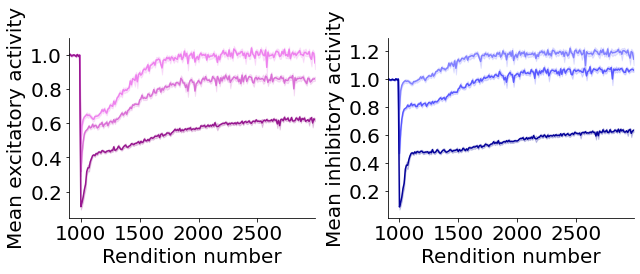

In [65]:
make_total_activity_plot([
    ['DROP_SEV_0.1', 'secreted_regulation', 'A5_0.5'],
    ['DROP_SEV_0.25','secreted_regulation', 'A5_0.5'],
    ['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5']
],
    ['1', '2', '3'], color_sets, n_excs=[200, 200, 200], ylim1=None, ylim2=None,
    ylabel1=None, ylabel2=None, timepoints=np.arange(900, 3000, 10), offsets=[990, 990, 990], vertical_spacing=0.,
    tick_right=False, legend=True)

['DROP_SEV_0.1', 'firing_rate', 'A5_0.5']
['DROP_SEV_0.25', 'firing_rate', 'A5_0.5']
['DROP_SEV_0.5', 'firing_rate', 'A5_0.5']
secreted__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:1805
secreted__SEED_2010_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:0424
secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:2681
secreted__SEED_2012_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:0713
secreted__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.1_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:7375
secreted__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e

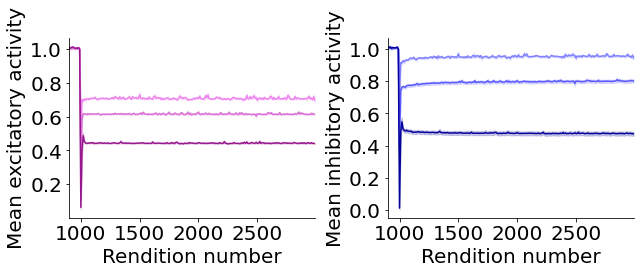

In [34]:
make_total_activity_plot([
    ['DROP_SEV_0.1', 'firing_rate', 'A5_0.5'],
    ['DROP_SEV_0.25','firing_rate', 'A5_0.5'],
    ['DROP_SEV_0.5', 'firing_rate', 'A5_0.5']
],
    ['1', '2', '3'], color_sets, n_excs=[200, 200, 200], ylim1=None, ylim2=None,
    ylabel1=None, ylabel2=None, timepoints=np.arange(900, 3000, 10), offsets=[990, 990, 990], vertical_spacing=0.,
    tick_right=False, legend=True)

In [2]:
def make_figure_2_plot(names, labels, condition_colors, n_excs=[450], file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 2.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        
        count = 0
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
#             if count >= 3:
#                 continue
            count += 1

            print(exp_dir_name)
                    
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, n_exc=n_excs[idx], name_frags=[], new_cell_idx=200):
                
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights_e_e'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights_e_e'])
                all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == offsets[idx]:
                    baseline_mean = data['mean_incoming_summed_weights_e_e']
                    baseline_std = data['std_incoming_summed_weights_e_e']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
            
#             if np.max(all_mean_incoming_summed_weights) < 8:
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
            all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
#                 axs[0].plot(timepoints[:len(all_mean_incoming_summed_weights)] * 10, all_mean_incoming_summed_weights, color=condition_colors[idx][0], lw=0.5, zorder=-1)
#                 axs[1].plot(timepoints[:len(all_mean_incoming_summed_weights_e_i)] * 10, all_mean_incoming_summed_weights_e_i, color=condition_colors[idx][1], lw=0.5, zorder=-1)

        
        if len(all_weights_for_dir_name) == 0:
            continue
        
        e_e_means = safe_apply_stat(all_weights_for_dir_name, np.mean)
        e_e_sems = safe_apply_stat(all_weights_for_dir_name, lambda x: np.std(x))
        e_i_means = safe_apply_stat(all_weights_e_i_for_dir_name, np.mean)
        e_i_sems = safe_apply_stat(all_weights_e_i_for_dir_name, lambda x: np.std(x) )

        y_disp = vertical_spacing * idx
        trimmed_timepoints = timepoints[:len(e_e_means)]

        axs[0].fill_between(
            trimmed_timepoints,
            e_e_means - e_e_sems + y_disp,
            e_e_means + e_e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(trimmed_timepoints, e_e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        axs[1].fill_between(
            trimmed_timepoints,
            e_i_means - e_i_sems + y_disp,
            e_i_means + e_i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2, zorder=-1)
        axs[1].plot(trimmed_timepoints, e_i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx], zorder=-1)

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
#             axs[i].set_xlim(10 * timepoints[0], 10 * timepoints[-1])
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 14)
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
    if legend:
        axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

In [3]:
def extract_weight_dist_stats(names, recovered_exp_names, timepoints, n_exc=300, new_cell_idx=200):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    all_weight_dist_info = []
    all_summed_weights = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        
        summed_weights_for_group = [[] for t in timepoints]
        summed_weights_for_group_perturbed = [[] for t in timepoints]
        weight_freqs_for_group = [[] for t in timepoints]
        weight_bins = [[] for t in timepoints]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            t_ctr = 0
            for k, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, name_frags=[], n_exc=n_exc, new_cell_idx=new_cell_idx):
                summed_incoming_weights = data['summed_incoming_weights_e_e']
                summed_weights_for_group[t_ctr].append(summed_incoming_weights)
                
                bins, freqs = bin_occurrences(summed_incoming_weights, max_val=0.0035, bin_size=0.00001)
                weight_bins[t_ctr] = bins
                weight_freqs_for_group[t_ctr].append(freqs)
                
                t_ctr += 1
        
        mean_weight_dists = []
        std_weight_dists = []
        summed_weight_bins = []
        
        mean_summed_incoming_weights = []
        std_summed_incoming_weights = []
        all_summed_incoming_weights = []
        
        all_summed_incoming_weights_perturbed = []
        
        for i_t, t in enumerate(timepoints):
            mean_weight_dists.append(np.nanmean(weight_freqs_for_group[i_t], axis=0))
            std_weight_dists.append(np.nanstd(weight_freqs_for_group[i_t], axis=0))
            summed_weight_bins.append(weight_bins[i_t])
            
            all_summed_incoming_weights.append(np.array(summed_weights_for_group[i_t]).flatten())
            mean_summed_incoming_weights.append(np.nanmean(summed_weights_for_group[i_t], axis=0).flatten())
            std_summed_incoming_weights.append(np.nanstd(summed_weights_for_group[i_t], axis=0).flatten())
                
        all_weight_dist_info.append({
                'mean_weight_dists': mean_weight_dists,
                'std_weight_dists': std_weight_dists,
                'summed_weight_bins': summed_weight_bins[0],
                'mean_summed_incoming_weights': mean_summed_incoming_weights,
                'std_summed_incoming_weights': std_summed_incoming_weights,
                'all_summed_incoming_weights': all_summed_incoming_weights,
        })
    return all_weight_dist_info

In [23]:
all_weight_dist_info_1 = extract_weight_dist_stats([
    ['DROP_SEV_0.25', 'secreted_regulation', 'A5_0.5'],
], recovered_exp_names, [990, 1500, 4000], n_exc=200)

secreted__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--44:5704
secreted__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0602
secreted__SEED_2022_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0093
secreted__SEED_2017_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0209
secreted__SEED_2010_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0424
secreted__SEED_2012_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn

In [24]:
all_weight_dist_info_2 = extract_weight_dist_stats([
    ['DROP_SEV_0.25', 'firing_rate', 'A5_0.5'],
], recovered_exp_names, [990, 1500, 4000], n_exc=200)

secreted__SEED_2018_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:8822
secreted__SEED_2019_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:9033
secreted__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:1805
secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:6059
secreted__SEED_2004_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:5876
secreted__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:5704
secreted__

In [35]:
def make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info, names, dist_timepoints, n_excs=[300], new_cell_idx=200, exc_cell_color='black', inh_cell_color='blue', ylim=(0, 1), ylim2=(0, 1)):
    scale = 1.3
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8 * scale, 4 * scale))
    plt.locator_params(axis='x', nbins=6)

    dist_timepoints = np.array(dist_timepoints)
    colors = get_equally_spaced_colors(3, cmap='winter')

    for k, dist_data_for_name in enumerate(all_weight_dist_info):
        if len(dist_data_for_name) > 0:
            axs[1].set_ylabel('Summed synaptic strength')
            axs[1].yaxis.set_label_position('right')
            axs[1].yaxis.tick_right()
            axs[0].set_ylim(ylim2)
            axs[1].set_ylim(ylim)
            
            axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))
                        
            widths = 0.9
            
            mean_initial_summed_incoming_weight = np.mean(dist_data_for_name['all_summed_incoming_weights'][0])
            normalized_data = dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight
            
            parts = axs[1].violinplot(normalized_data, positions= 1 + np.arange(len(normalized_data)), showmeans=False, showextrema=False, widths=widths)
            for pc in parts['bodies']:
                pc.set_facecolor(exc_cell_color)
    #             pc.set_edgecolor('black')
                pc.set_alpha(0.15)

            num_to_sample = 100
            for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
                indices_to_show = np.arange(len(normalized_data[i]))
                np.random.shuffle(indices_to_show)
                indices_to_show = indices_to_show[:num_to_sample]
                
                axs[1].scatter(i + 1 + np.random.normal(size=num_to_sample, scale=0.05), normalized_data[i][indices_to_show],
                            s=10, color=exc_cell_color, zorder=3)
            axs[1].set_xticks([1, 2, 3])
            axs[1].set_xticklabels([
                'Initial',
                r'$1200^{th}$' + '\nrendition',
                r'$2500^{th}$'  + '\nrendition'
            ])
            axs[1].set_ylabel('Normalized summed \nsynaptic strength')
        
            axs[0].spines['top'].set_visible(False)
            axs[0].spines['right'].set_visible(False)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['left'].set_visible(False)
        
#             axs[0].tick_params(right=True, labelright=True)

            timepoints_start = dist_timepoints[0] - 10 if dist_timepoints[0] - 10 > 0 else 0
            timepoints = np.arange(timepoints_start, dist_timepoints[-1] + 30, 10)

            make_figure_2_plot(names, labels=['', '', ''],
            condition_colors=color_sets[1:], timepoints=timepoints, offsets=dist_timepoints[0] * np.ones(20), vertical_spacing=0.,
            file_name_ext='', axs=[axs[0], axs[0]], fig=fig, tick_right=False, legend=False, ylabel2='Normalized summed \nsynapse strength', n_excs=n_excs)
            set_font_size(axs[0], 14)
            set_font_size(axs[1], 14)
            
            save_fig(fig, './figures/paper/weight_trajectories', f'{k}.svg')

['DROP_SEV_0.25', 'secreted_regulation', 'A5_0.5']
['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5']
secreted__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--44:5704
secreted__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0602
secreted__SEED_2022_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0093
secreted__SEED_2017_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0209
secreted__SEED_2010_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0424
secreted__SEED_2012_W_E_

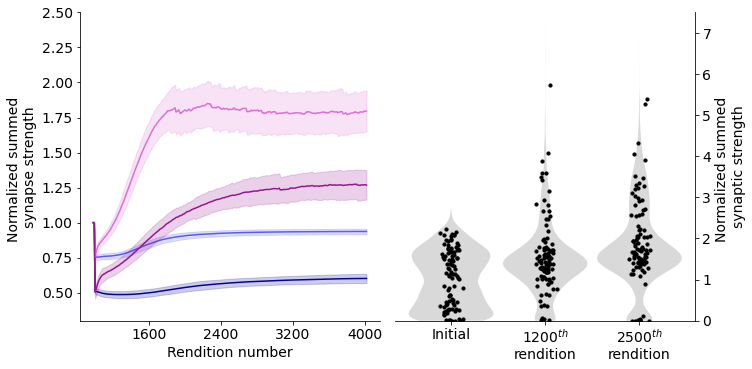

In [36]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_1, [
    ['DROP_SEV_0.25', 'secreted_regulation', 'A5_0.5'],
    ['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5'],
], dist_timepoints=[990, 1500, 4000], n_excs=[200, 200, 200], ylim=(0, 7.5), ylim2=(0.3, 2.5))


In [1]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_2, [
    ['DROP_SEV_0.25', 'firing_rate', 'A5_0.5'],
    ['DROP_SEV_0.5', 'firing_rate', 'A5_0.5'],
], dist_timepoints=[990, 1500, 4000], n_excs=[200, 200, 200], ylim=(0, 7.5), ylim2=(0.3, 1.5))


NameError: name 'make_interpolated_violin_plot_and_weight_traj' is not defined

In [9]:
def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

In [10]:
def sliding_window_activity(raster, window_size, dt, interval):
    window_size_discrete = int(window_size / dt)
    all_spk_times = np.sort(raster[0, :])
    all_t = np.arange(interval[0], interval[1], dt)
    activity = np.zeros(all_t.shape)
    
    for i_t, t in enumerate(all_t):
        window_start = bisect_left(all_spk_times, t - window_size)
        window_end = bisect_left(all_spk_times, t + window_size)
        activity[i_t] = len(all_spk_times[window_start:window_end])
    return all_t, activity

def find_sequence_end(trace, t):
    t_ctr = len(trace) - 1
    while trace[t_ctr] == 0:
        t_ctr -= 1
    return t[t_ctr + 1]

def find_sequence_beginning(trace, t):
    t_ctr = 0
    while trace[t_ctr] == 0:
        t_ctr += 1
    return t[t_ctr - 1]

def find_seq_duration(trace, t):
#     print(find_sequence_end(trace, t))
#     print(find_sequence_beginning(trace, t))
    return find_sequence_end(trace, t) - find_sequence_beginning(trace, t)

def make_duration_graphs(name, timepoints=[0, 72, 73], n_exc=450, new_cell_idx=None):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
       
    scale = 0.8
    n_plots = 1
    fig = plt.figure(constrained_layout=True, figsize=(7 * scale, 5 * n_plots * scale))
    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    axs = [fig.add_subplot(gs[i]) for i in range(n_plots)]
    
    colors = get_ordered_colors('gist_ncar', 30)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
        
        old_activity_durations = []
        total_activity_durations = []
        
#         if d_idx > 10:
#             continue

        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, reverse=False, n_exc=n_exc, new_cell_idx=new_cell_idx):
            exc_raster = data['exc_raster_unperturbed']

            exc_raster_old = exc_raster[:, exc_raster[1, :] < new_cell_idx]
            exc_raster_new = exc_raster[:, exc_raster[1, :] >= new_cell_idx]

            inh_raster = data['inh_raster']

            t, e_old_activity_trace = sliding_window_activity(exc_raster_old, 3e-3, dt, (0, 0.14))
            t, e_new_activity_trace = sliding_window_activity(exc_raster_new, 3e-3, dt, (0, 0.14))
            t, e_activity_trace = sliding_window_activity(np.concatenate([exc_raster_old, exc_raster_new], axis=1), 3e-3, dt, (0, 0.14))
            t, i_activity_trace = sliding_window_activity(inh_raster, 3e-3, dt, (0, 0.14))

            t = 1000 * t

            e_old_duration = find_seq_duration(e_old_activity_trace, t)
            e_total_duration = find_seq_duration(e_activity_trace, t)

            old_activity_durations.append(e_old_duration)
            total_activity_durations.append(e_total_duration)
        
        total_activity_durations = np.array(total_activity_durations)
#         axs[0].plot(timepoints[:len(old_activity_durations)], old_activity_durations, lw=0.5, c='black')
        def norm(arr):
            return (arr - arr.min()) / (arr.max() - arr.min())

        axs[0].scatter(timepoints[:len(total_activity_durations)], 100 * total_activity_durations / np.mean(total_activity_durations[:50]), s=2, color=colors[d_idx])
        
    axs[0].set_ylabel('Activation duration')
    axs[0].set_xlabel('Rendition No.')
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].set_xlim(timepoints[0], timepoints[-1])
    set_font_size(axs[0], 14)
    plt.locator_params(axis='y', nbins=6)
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter())

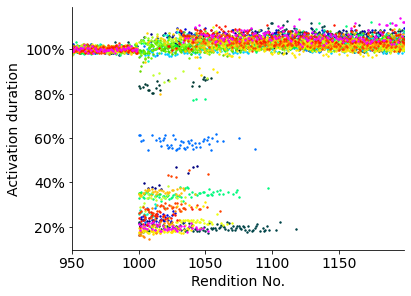

In [11]:
make_duration_graphs(['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5'],
                           timepoints=np.arange(950, 1200), n_exc=200, new_cell_idx=200)

In [31]:
def make_duration_dist_graphs(name, timepoints=[0, 72, 73], n_exc=450, new_cell_idx=None, rendition_batch_size=50):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
       
    scale = 2
    n_plots = int(np.ceil((timepoints[-1] - timepoints[0]) / rendition_batch_size))
    
    colors = get_ordered_colors('gist_ncar', 30)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
            
        fig, axs = plt.subplots(n_plots, 1, sharex=True, sharey=True, figsize=(3 * scale, 3  * scale))

        old_activity_durations = []
        total_activity_durations = []

        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, reverse=False, n_exc=n_exc, new_cell_idx=new_cell_idx):
            exc_raster = data['exc_raster_unperturbed']

            exc_raster_old = exc_raster[:, exc_raster[1, :] < new_cell_idx]
            exc_raster_new = exc_raster[:, exc_raster[1, :] >= new_cell_idx]

            inh_raster = data['inh_raster']

            t, e_old_activity_trace = sliding_window_activity(exc_raster_old, 3e-3, dt, (0, 0.14))
            t, e_new_activity_trace = sliding_window_activity(exc_raster_new, 3e-3, dt, (0, 0.14))
            t, e_activity_trace = sliding_window_activity(np.concatenate([exc_raster_old, exc_raster_new], axis=1), 3e-3, dt, (0, 0.14))
            t, i_activity_trace = sliding_window_activity(inh_raster, 3e-3, dt, (0, 0.14))

            t = 1000 * t

            e_old_duration = find_seq_duration(e_old_activity_trace, t)
            e_total_duration = find_seq_duration(e_activity_trace, t)

            old_activity_durations.append(e_old_duration)
            total_activity_durations.append(e_total_duration)
        
        total_activity_durations = np.array(total_activity_durations)
        for l in np.arange(0, timepoints[-1] - timepoints[0], rendition_batch_size):
            batch_durations = total_activity_durations[l:l+rendition_batch_size]
            axs[int(l/rendition_batch_size)].hist(batch_durations, bins=25, range=(0, 100), color=color_sets[2][0])
            axs[int(l/rendition_batch_size)].spines['right'].set_visible(False)
            axs[int(l/rendition_batch_size)].spines['top'].set_visible(False)
            set_font_size(axs[int(l/rendition_batch_size)], 14)
        
        axs[-1].set_xlabel('Duration (ms)')
        axs[0].set_ylabel('Counts')
        plt.locator_params(axis='y', nbins=2)
        fig.tight_layout()
        

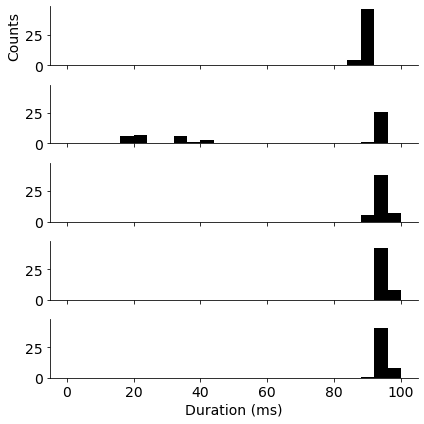

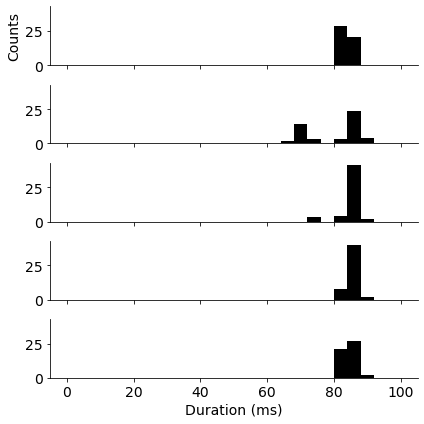

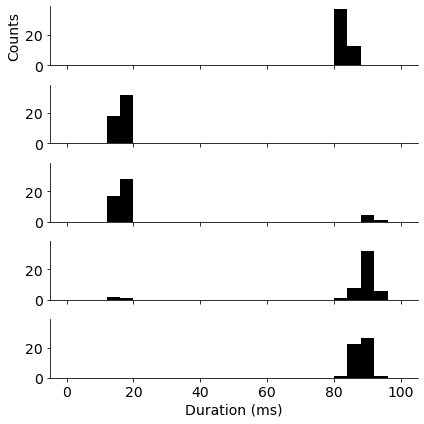

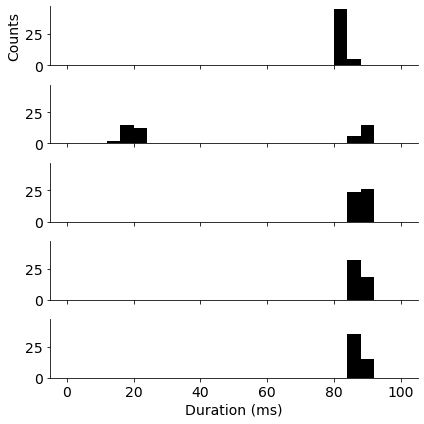

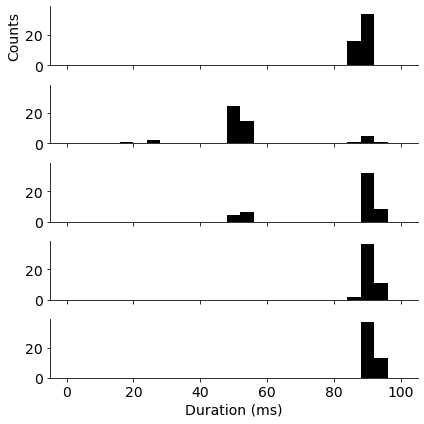

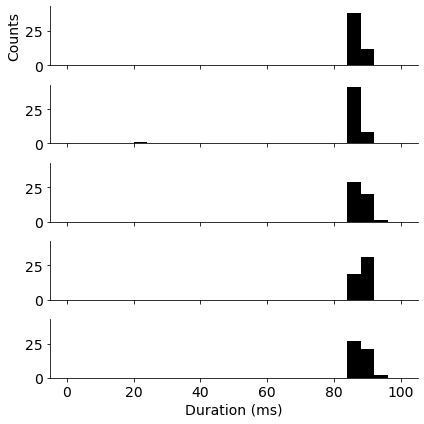

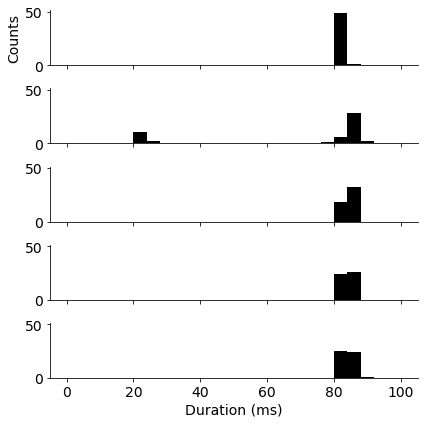

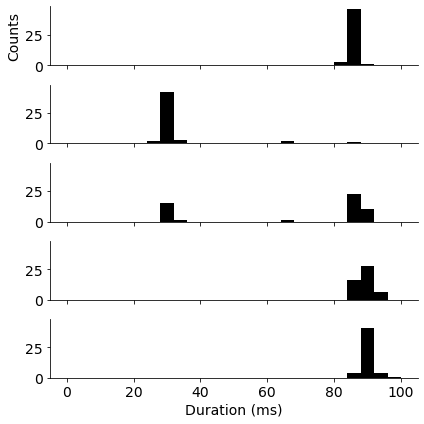

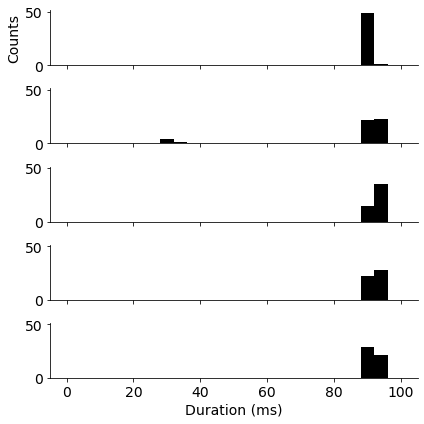

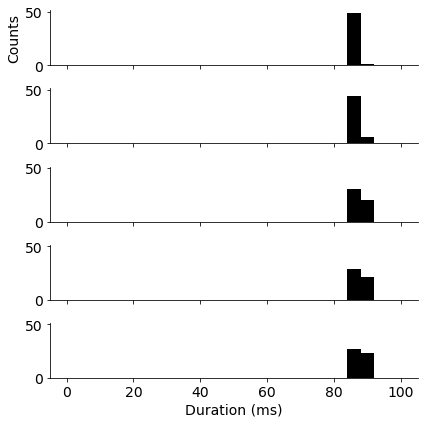

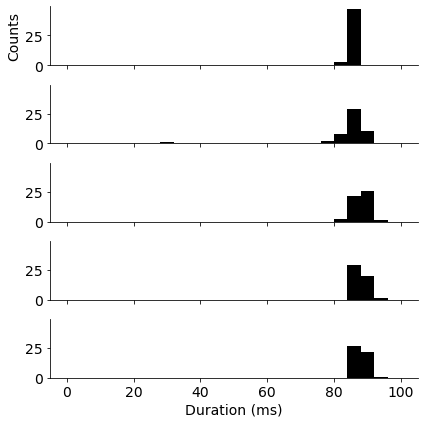

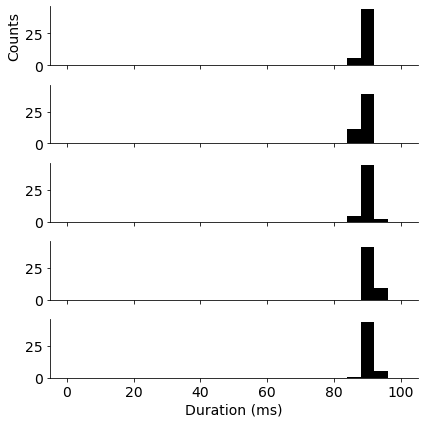

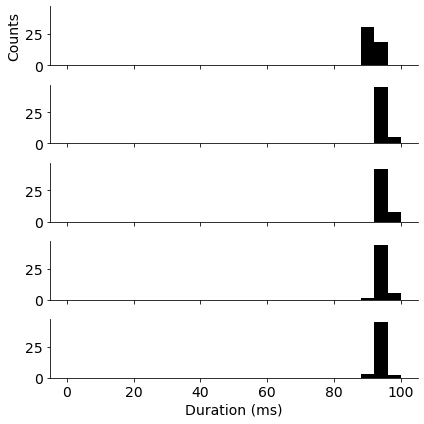

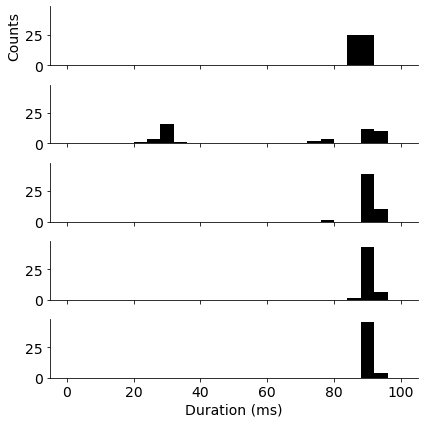

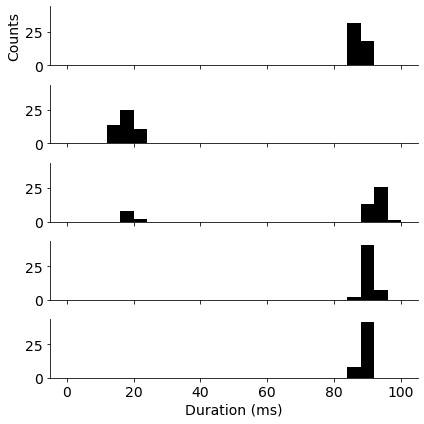

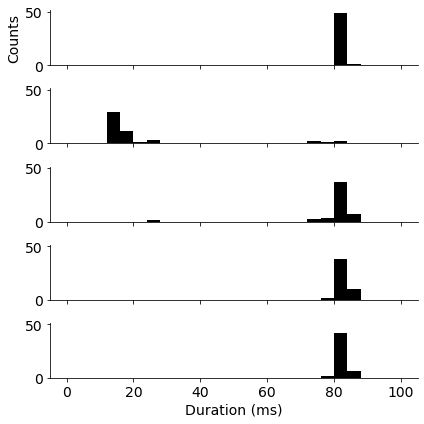

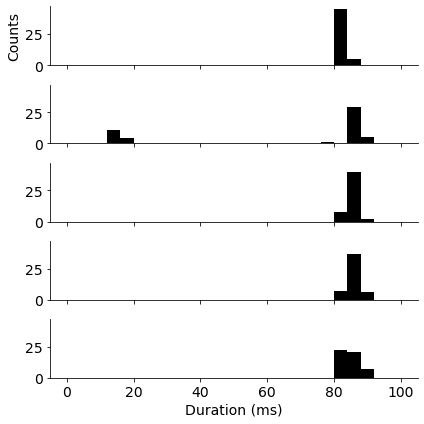

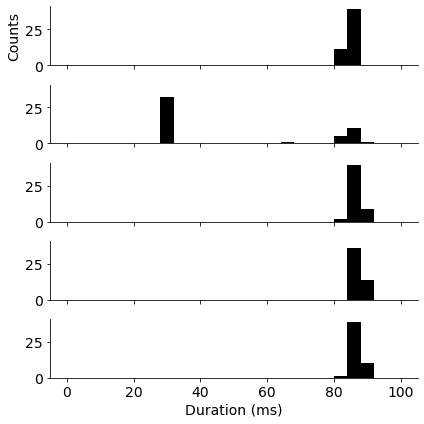

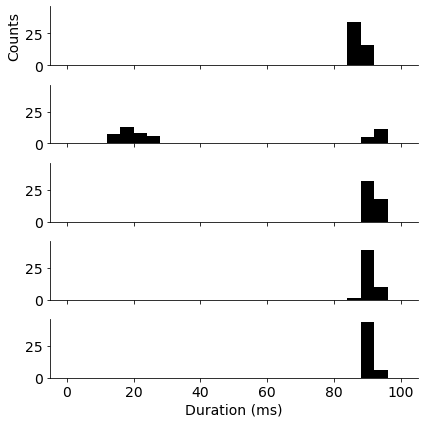

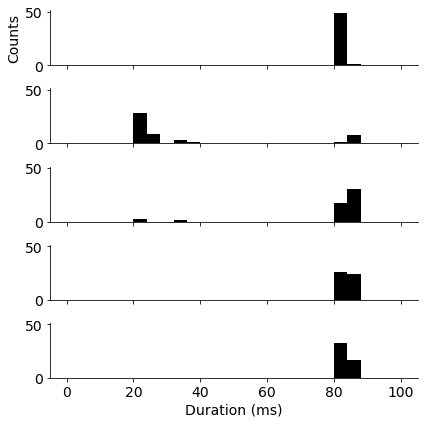

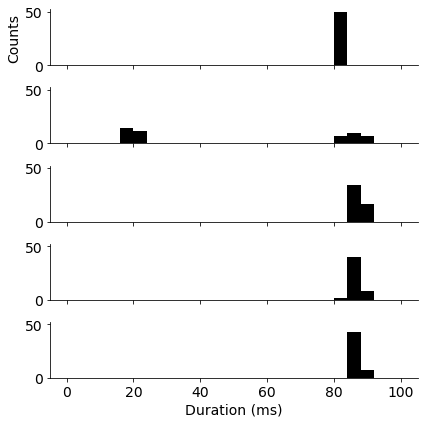

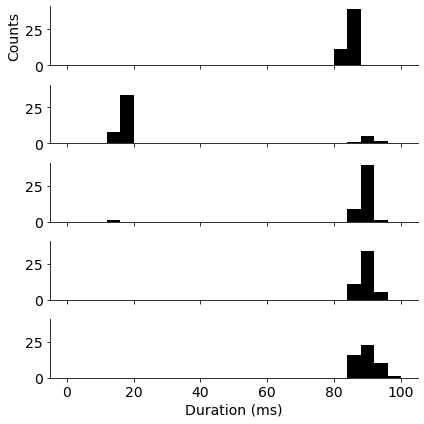

In [53]:
make_duration_dist_graphs(['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5'],
                           timepoints=np.arange(950, 1200), n_exc=200, new_cell_idx=200)

In [14]:
def make_duration_mode_graphs(name, timepoints=[0, 72, 73], n_exc=450, new_cell_idx=None, rendition_batch_size=20):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_ordered_colors('gist_ncar', 30)
    
    scale = 0.8
    n_plots = 1
    fig = plt.figure(constrained_layout=True, figsize=(7 * scale, 5 * n_plots * scale))
    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    axs = [fig.add_subplot(gs[i]) for i in range(n_plots)]
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
            
        old_activity_durations = []
        total_activity_durations = []

        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, reverse=False, n_exc=n_exc, new_cell_idx=new_cell_idx):
            exc_raster = data['exc_raster_unperturbed']

            exc_raster_old = exc_raster[:, exc_raster[1, :] < new_cell_idx]
            exc_raster_new = exc_raster[:, exc_raster[1, :] >= new_cell_idx]

            inh_raster = data['inh_raster']

            t, e_old_activity_trace = sliding_window_activity(exc_raster_old, 3e-3, dt, (0, 0.14))
            t, e_new_activity_trace = sliding_window_activity(exc_raster_new, 3e-3, dt, (0, 0.14))
            t, e_activity_trace = sliding_window_activity(np.concatenate([exc_raster_old, exc_raster_new], axis=1), 3e-3, dt, (0, 0.14))
            t, i_activity_trace = sliding_window_activity(inh_raster, 3e-3, dt, (0, 0.14))

            t = 1000 * t

            e_old_duration = find_seq_duration(e_old_activity_trace, t)
            e_total_duration = find_seq_duration(e_activity_trace, t)

            old_activity_durations.append(e_old_duration)
            total_activity_durations.append(e_total_duration)
        
        all_modes = []
        
        total_activity_durations = np.array(total_activity_durations)
        for l in np.arange(0, timepoints[-1] - timepoints[0], rendition_batch_size):
            batch_durations = total_activity_durations[l:l+rendition_batch_size]
            bins, vals = bin_occurrences(batch_durations, min_val=0, max_val=100, bin_size=4)
            
            all_modes.append(bins[np.argmax(vals)])
        
        axs[0].plot(np.arange(timepoints[0], timepoints[-1], rendition_batch_size), 100 * np.array(all_modes) / all_modes[0], lw=0.7, color=colors[d_idx])
        
    axs[0].set_ylabel('Mode of sequence duration')
    axs[0].set_xlabel('Rendition No.')
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].set_xlim(timepoints[0] - 10, timepoints[-1] + 10)
    set_font_size(axs[0], 14)
    plt.locator_params(axis='y', nbins=6)
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter())

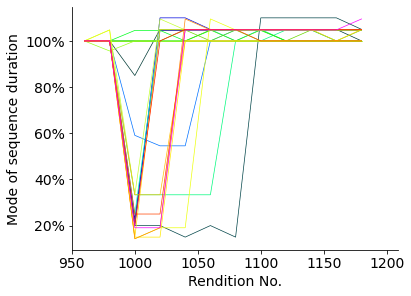

In [15]:
make_duration_mode_graphs(['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5'],
                           timepoints=np.arange(960, 1200), n_exc=200, new_cell_idx=200)

In [53]:
def make_timing_precision_graphs(names, timepoints=[600], n_exc=200, new_cell_idx=200, period=50):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        scale = 1.1
        fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
        axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
        
        all_avg_timing_entropies = []
        all_avg_percents_active = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            avg_percents_active = []
            avg_timing_entropy = []
            
            spikes_for_period = [[] for l in range(n_exc)]
            cells_active_for_period = []

            for tp, data in load_exp_data(os.path.join('./robustness', exp_dir_name), timepoints, n_exc=n_exc):
                if tp == timepoints[-1] or (tp % period == 0 and tp != timepoints[0]):
                    entropies_for_period = []
                    for l in range(n_exc):
                        if len(spikes_for_period[l]) > 0:
                            bins, vals = bin_occurrences(np.array(spikes_for_period[l]), min_val=0, max_val=0.14, bin_size=0.01)
                            entropies_for_period.append(stats.entropy(vals / np.sum(vals)))
                            
                    cells_active_for_period = np.array(cells_active_for_period)
                    percents_active = np.mean(cells_active_for_period, axis=0)
                    
                    avg_timing_entropy.append(np.nanmean(entropies_for_period))
                    avg_percents_active.append(np.nanmean(percents_active[percents_active > 0.001]))
                    
                    entropies_for_period = []
                    cells_active_for_period = []
                
                cells_active_for_rendition = np.zeros((n_exc))
                
                exc_raster_unperturbed = data['exc_raster_unperturbed']
                for k, cell_idx in enumerate(exc_raster_unperturbed[1, :]):
                    spikes_for_period[int(cell_idx)].append(exc_raster_unperturbed[0, k])
                    cells_active_for_rendition[int(cell_idx)] = 1
                    
                cells_active_for_period.append(cells_active_for_rendition)
            
            all_avg_percents_active.append(avg_percents_active)
            all_avg_timing_entropies.append(avg_timing_entropy)
            
        all_avg_percents_active = np.array(all_avg_percents_active)
        all_avg_timing_entropies = np.array(all_avg_timing_entropies)

        axs[0].plot(timepoints[np.arange(0, len(timepoints), period)], np.nanmean(all_avg_percents_active, axis=0), lw=1, c='red', zorder=0, alpha=1)
        axs[0].locator_params(axis='x', nbins=5)
        axs[1].plot(timepoints[np.arange(0, len(timepoints), period)], np.nanmean(all_avg_timing_entropies, axis=0), lw=1, c='red', zorder=0, alpha=1)
        axs[1].locator_params(axis='x', nbins=5)
        
        for axs_idx in range(2):
            set_font_size(axs[axs_idx], 16)
            axs[axs_idx].spines['right'].set_visible(False)
            axs[axs_idx].spines['top'].set_visible(False)
            axs[axs_idx].set_xlabel('Rendition No.')
        
        axs[0].set_ylabel('Mean individual neuron\nrate of participation')
        axs[1].set_ylabel('Mean entropy in single\nneuron spike timing')
#         axs[0].set_ylim(0, 0.0025)
#         axs[0].set_xlim(0.05)

secreted__SEED_2008_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:2681
secreted__SEED_2002_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6544
secreted__SEED_2007_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6435
secreted__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:1805
secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:6059
secreted__SEED_2015_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_S

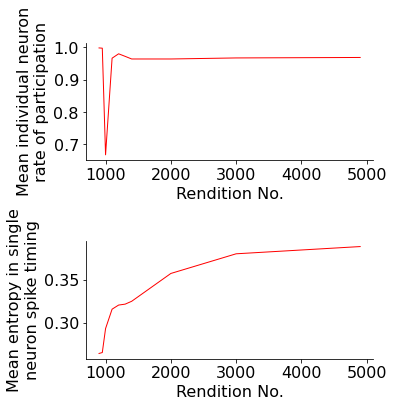

In [54]:
make_timing_precision_graphs([
    ['DROP_SEV_0.5', 'secreted_regulation', 'A5_0.5'],
],  np.concatenate([
    np.arange(900, 950),
    np.arange(950, 1000),
    np.arange(1000, 1050),
    np.arange(1100, 1150),
    np.arange(1200, 1250),
    np.arange(1300, 1350),
    np.arange(1400, 1450),
    np.arange(2000, 2050),
    np.arange(3000, 3050),
    np.arange(4900, 4950)
]), n_exc=200)


secreted__SEED_2000_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--44:5704
secreted__SEED_2009_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0602
secreted__SEED_2022_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0093
secreted__SEED_2017_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0209
secreted__SEED_2010_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn_PER_SILENT_0.4_A5_0.5_2022-08-01--15:09--43:0424
secreted__SEED_2012_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.25_COMP_MECH_secreted_regulation_CONDITION_no_repl_no_syn

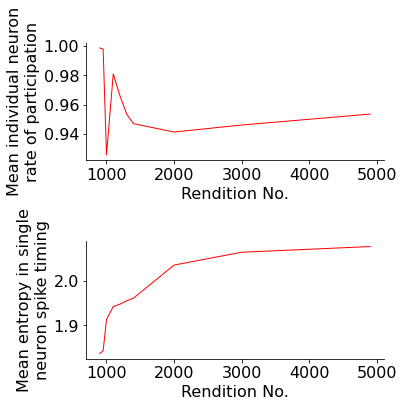

In [42]:
make_timing_precision_graphs([
    ['DROP_SEV_0.25', 'secreted_regulation', 'A5_0.5'],
],  np.concatenate([
    np.arange(900, 950),
    np.arange(950, 1000),
    np.arange(1000, 1050),
    np.arange(1100, 1150),
    np.arange(1200, 1250),
    np.arange(1300, 1350),
    np.arange(1400, 1450),
    np.arange(2000, 2050),
    np.arange(3000, 3050),
    np.arange(4900, 4950)
]), n_exc=200)


secreted__SEED_2010_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:0424
secreted__SEED_2005_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:1805
secreted__SEED_2012_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:0713
secreted__SEED_2013_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:6753
secreted__SEED_2021_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:6059
secreted__SEED_2014_W_E_E_0.0012_W_E_I_7e-05_W_I_E_4e-05_DROP_SEV_0.5_COMP_MECH_firing_rate_CONDITION_no_repl_no_syn_PER_SILENT_0_A5_0.5_2022-08-01--15:11--06:1855
secreted__SEED_2

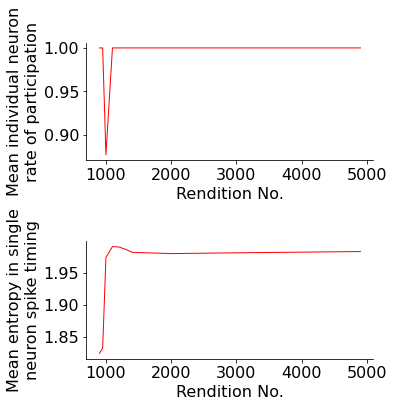

In [21]:
make_timing_precision_graphs([
    ['DROP_SEV_0.5', 'firing_rate', 'A5_0.5'],
],  np.concatenate([
    np.arange(900, 950),
    np.arange(950, 1000),
    np.arange(1000, 1050),
    np.arange(1100, 1150),
    np.arange(1200, 1250),
    np.arange(1300, 1350),
    np.arange(1400, 1450),
    np.arange(2000, 2050),
    np.arange(3000, 3050),
    np.arange(4900, 4950)
]), n_exc=200)


In [ ]:
def make_timing_error_graphs(names, timepoints_1, timepoints_2, n_exc=300, new_cell_idx=200):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        scale = 1.1
        fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
        axs = [fig.add_subplot(gs[:, 0])]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            j = 0
            all_first_spk_times = []

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
                if j < len(timepoints) and i == timepoints[j]:
                    data = load_data()
                    first_spk_times = data['first_spk_times']
                    original_surviving_mask = np.arange(n_exc) < new_cell_idx     
                    if 'surviving_cell_mask' in data:
                        original_surviving_mask = np.logical_and(original_surviving_mask, data['surviving_cell_mask']).astype(bool)
                    first_spk_times = data['first_spk_times'][original_surviving_mask]
                    all_first_spk_times.append(first_spk_times)
                    j += 1
            
            all_first_spk_times = np.stack(all_first_spk_times)
            all_nan_means = np.nanmean(all_first_spk_times, axis=0)
            all_nan_stds = np.nanstd(all_first_spk_times, axis=0)

            axs[0].scatter(all_nan_means, all_nan_stds, s=2, c='black', zorder=0, alpha=1)

        set_font_size(axs[0], 16)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['top'].set_visible(False)

        axs[0].set_xlabel('Firing time (s)')
        axs[0].set_ylabel('First spike STD (s)')

        axs[0].set_ylim(0, 0.0025)
        axs[0].set_xlim(0.05)

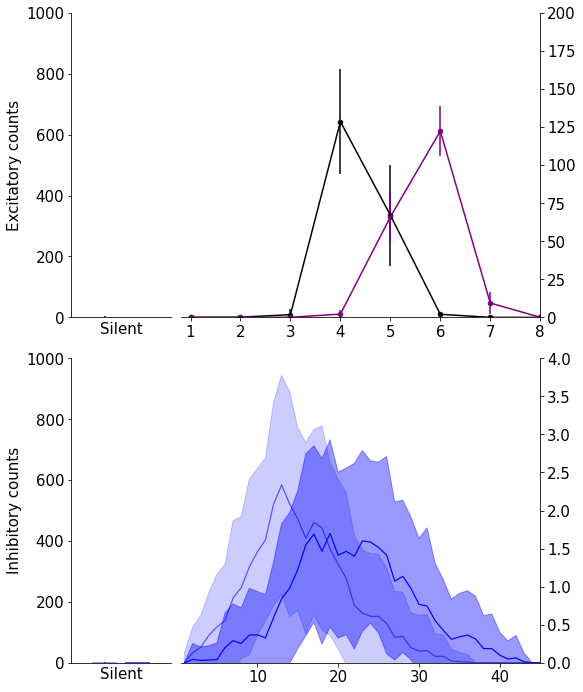

In [168]:
make_figure_3b(
    ['low_growth', 'DROP_SEV_0.5', 'CONDITION_no_repl_PER_SILENT_0_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259))

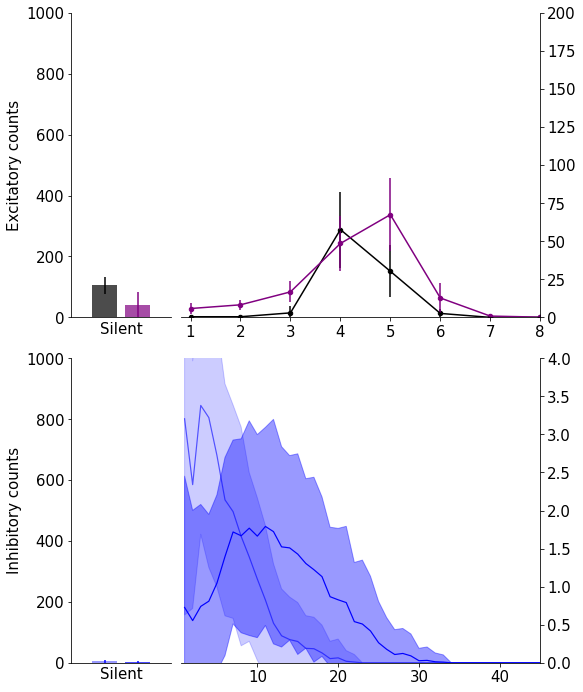

In [170]:
make_figure_3b(
    ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259))

In [218]:
def make_figure_3c(name, ylim=(0, 8), initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259), n_exc=200, color='blue', xlim1=(0, 10), xlim2=(0, 10), ylim1=(0, 10), ylim2=(0, 10)):    
    all_dirs = [dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)]
            
    labels = [
        'unperturbed',
        '1500th rendition',
    ]
    
    scale = 1.9
    fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
    gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    def create_split_freq_plot(row_start, row_end, col_start, fig, gs):
        sub_axs = [
            fig.add_subplot(gs[row_start:row_end, col_start:(col_start+3)])
        ]
#         sub_axs[0].yaxis.tick_right()
        sub_axs[0].set_xlim(0, 45)
        sub_axs[0].set_ylim(0, 1000)
#         sub_axs[0].spines['left'].set_visible(False)
        sub_axs[0].spines['top'].set_visible(False)
        return sub_axs
    
    axs = [
        create_split_freq_plot(0, 1, 0, fig, gs),
        create_split_freq_plot(1, 2, 0, fig, gs),
    ]
    
    
    firing_rate_stats_initial = {
        'spk_bins_e': None,
        'freqs_e': [],
        'spk_bins_i': None,
        'freqs_i': [],
    }
    firing_rate_stats_final = copy(firing_rate_stats_initial)
           
    for idx, exp_dir_name in enumerate(all_dirs):
        for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
            if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]) or (i >= final_timepoint_range[0] and i <= final_timepoint_range[1]):
                    data = data_load()

                    spk_bins_e = data['spk_bins']
                    freqs_e = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=n_exc, max_val=n_exc + 30, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                        
                    if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]):
                        firing_rate_stats = firing_rate_stats_initial
                    else:
                        firing_rate_stats = firing_rate_stats_final
                        
                    if firing_rate_stats['spk_bins_e'] is None:
                        firing_rate_stats['spk_bins_e'] = spk_bins_e
                    if firing_rate_stats['spk_bins_i'] is None:
                        firing_rate_stats['spk_bins_i'] = spk_bins_i
                    firing_rate_stats['freqs_e'].append(freqs_e)
                    firing_rate_stats['freqs_i'].append(freqs_i)
        
    for firing_rate_stats in [firing_rate_stats_initial, firing_rate_stats_final]:
        firing_rate_stats['freqs_e_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_e']), axis=0)[0])
        firing_rate_stats['freqs_i_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_i']), axis=0)[0])
        firing_rate_stats['freqs_e'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0), np.std(np.stack(firing_rate_stats['freqs_e']), axis=0))
        firing_rate_stats['freqs_i'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0), np.std(np.stack(firing_rate_stats['freqs_i']), axis=0))

    freqs_e_initial_low = firing_rate_stats_initial['freqs_e'][0] - firing_rate_stats_initial['freqs_e'][1]
    freqs_e_initial_high = firing_rate_stats_initial['freqs_e'][0] + firing_rate_stats_initial['freqs_e'][1]
    axs[0][0].fill_between(firing_rate_stats_initial['spk_bins_e'], y1=freqs_e_initial_low, y2=freqs_e_initial_high, color='black', alpha=0.15, zorder=-1)
    axs[0][0].plot(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, lw=1.2, label=labels[0])
#     axs[0][0].errorbar(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], yerr=firing_rate_stats_initial['freqs_e'][1], color='black', alpha=1., zorder=-1)
#     axs[0][0].scatter(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_initial_low = firing_rate_stats_initial['freqs_i'][0] - firing_rate_stats_initial['freqs_i'][1]
    freqs_i_initial_high = firing_rate_stats_initial['freqs_i'][0] + firing_rate_stats_initial['freqs_i'][1]
    axs[1][0].fill_between(firing_rate_stats_initial['spk_bins_i'], y1=freqs_i_initial_low, y2=freqs_i_initial_high, color='blue', alpha=0.15, zorder=-1)
    axs[1][0].plot(firing_rate_stats_initial['spk_bins_i'], firing_rate_stats_initial['freqs_i'][0], '--', color='blue', alpha=0.6, zorder=-1, lw=1.2, label=labels[0] + ' inh')

    freqs_e_final_low = firing_rate_stats_final['freqs_e'][0] - firing_rate_stats_final['freqs_e'][1]
    freqs_e_final_high = firing_rate_stats_final['freqs_e'][0] + firing_rate_stats_final['freqs_e'][1]
    axs[0][0].fill_between(firing_rate_stats_final['spk_bins_e'], y1=freqs_e_final_low, y2=freqs_e_final_high, color='purple', alpha=0.15, zorder=-1)
    axs[0][0].plot(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], color='purple', alpha=1., zorder=0, lw=1.2, label=labels[1])
#     axs[0][0].errorbar(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], yerr=firing_rate_stats_final['freqs_e'][1], color='purple', alpha=1., zorder=-1)
#     axs[0][0].scatter(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], color='purple', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_final_low = firing_rate_stats_final['freqs_i'][0] - firing_rate_stats_final['freqs_i'][1]
    freqs_i_final_high = firing_rate_stats_final['freqs_i'][0] + firing_rate_stats_final['freqs_i'][1]
    axs[1][0].fill_between(firing_rate_stats_final['spk_bins_i'], y1=freqs_i_final_low, y2=freqs_i_final_high, color='blue', alpha=0.15, zorder=-1)
    axs[1][0].plot(firing_rate_stats_final['spk_bins_i'], firing_rate_stats_final['freqs_i'][0], color='blue', alpha=1., zorder=0, lw=1.2, label=labels[1] + ' inh')

#     axs[0][0].errorbar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], yerr=firing_rate_stats_initial['freqs_e_zero'][1], color='black', alpha=1., zorder=-1)
#     axs[0][0].bar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], color='black', alpha=0.7, zorder=-1, width=0.75)
#     axs[0][0].errorbar(.5, firing_rate_stats_final['freqs_e_zero'][0], yerr=firing_rate_stats_final['freqs_e_zero'][1], color='purple', alpha=1., zorder=-1)
#     axs[0][0].bar(.5, firing_rate_stats_final['freqs_e_zero'][0], color='purple', alpha=0.7, zorder=-1, width=0.75)    

#     axs[1][0].errorbar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], yerr=firing_rate_stats_initial['freqs_i_zero'][1], color='blue', alpha=1., zorder=-1)
#     axs[1][0].bar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], color='blue', alpha=0.4, zorder=-1, width=0.75)
#     axs[1][0].errorbar(.5, firing_rate_stats_final['freqs_i_zero'][0], yerr=firing_rate_stats_final['freqs_i_zero'][1], color='blue', alpha=1., zorder=-1)
#     axs[1][0].bar(.5, firing_rate_stats_final['freqs_i_zero'][0], color='blue', alpha=0.7, zorder=-1, width=0.75)
    
    axs[0][0].set_ylabel('Excitatory counts')
    axs[1][0].set_ylabel('Inhibitory counts')
    axs[0][0].set_xlabel('Spikes per rendition')
    axs[1][0].set_xlabel('Spikes per rendition')
    axs[0][0].set_xlim(xlim1)
    axs[1][0].set_xlim(xlim2)
#     axs[0].spines['top'].set_visible(False)
#     axs[1].spines['top'].set_visible(False)
    axs[0][0].set_ylim(ylim1)
    axs[1][0].set_ylim(ylim2)
#     axs[1].set_ylim(0, 16)

#     axs[0].legend(frameon=False)
    
    for i in range(1):
        set_font_size(axs[0][i], 15)
        set_font_size(axs[1][i], 15)

    plt.locator_params(axis='x', nbins=5)
    
    save_fig(fig, './figures/paper/firing_rates', f'{" ".join(name)}.svg')

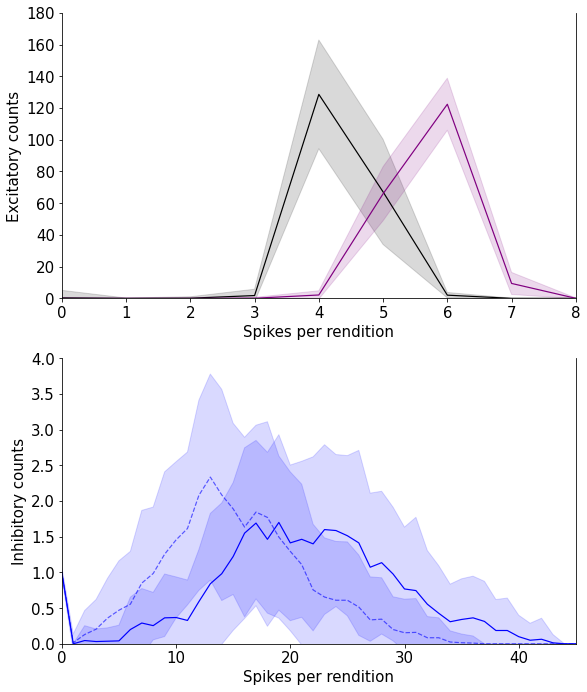

In [219]:
make_figure_3c(
    ['low_growth', 'DROP_SEV_0.5', 'CONDITION_no_repl_PER_SILENT_0_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259),
    xlim1=(0, 8), ylim1=(0, 180), xlim2=(0, 45), ylim2=(0, 4))

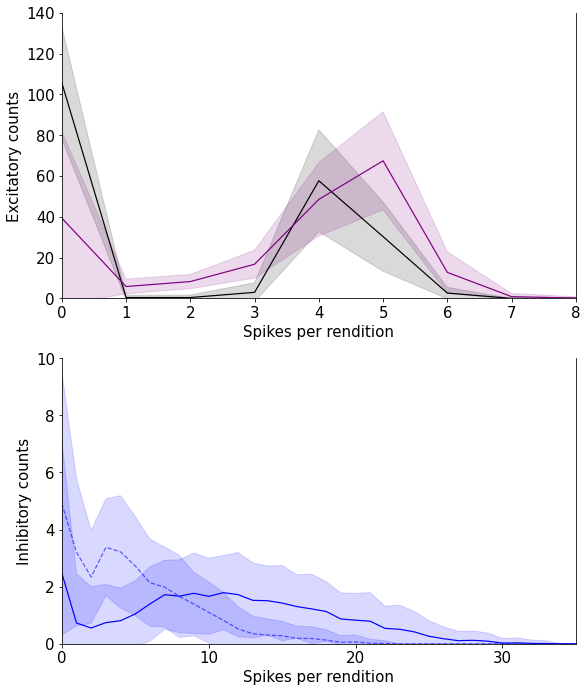

In [220]:
make_figure_3c(
    ['DROP_SEV_0.5', 'CONDITION_no_repl_no_syn_PER_SILENT_0.5_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259),
    xlim1=(0, 8), ylim1=(0, 140), xlim2=(0, 35), ylim2=(0, 10))

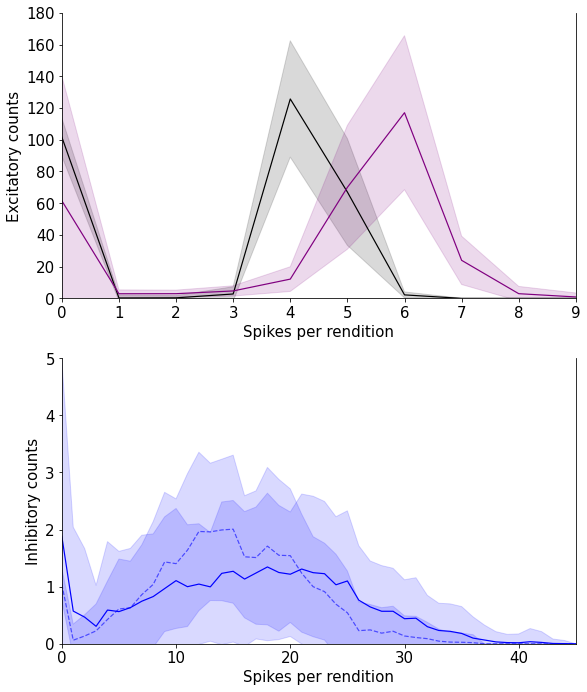

In [221]:
make_figure_3c(
    ['DROP_SEV_0.5', 'CONDITION_all_PER_SILENT_0_2022'],
    initial_timepoint_range=(90, 99), final_timepoint_range=(249, 259), n_exc=300,
    xlim1=(0, 9), ylim1=(0, 180), xlim2=(0, 45), ylim2=(0, 5))